<a href="https://colab.research.google.com/github/helenatong/oc_p2_analyse_exploratoire_dataset/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

---

## **Prérequis**
- Télécharger [le zip](https://drive.google.com/file/d/1Hw7gjd0cZQGi258_aosxPfC-RTSkcqJt/view?usp=sharing) dans Google Drive
- Modifier les chemins des fichiers (zip_path et extract_path) dans le code

 - 5 fichiers sont présents dans le zip: EdStatsCountry, EdStatsCountry-Series, EdStatsData, EdStatsFootNote, EdStatsSeries
 - Leurs noms respectifs dans ce notebook sont: country, country_series, data, foot_note, series


 ---

 ## **Contexte et description du notebook**
 La start-up academy connait une activité en forte croissance et sa nouvelle stratégie est d'aller conquérir un nouveau marché.

 En tant que data scientist, je me suis appuyée sur des données pour déterminer les marchés présentant le plus de potentiel et ainsi founir un outil d'aide à la décision.

 Pour ce faire, je me suis appuyée sur 5 bases de données disponibles sur le site de la Banque Mondiale.

 Dans ce notebook, les bases de données ont été explorées, ont été vérifiées sur le plan de leurs exploitabilité et enfin restructurées.

 Vous trouverez 2 études menées en parallèle, l'une porte sur les zones géographiques et l'autre sur les pays.

 Pour les pays, un double scoring a été effectué pour noter le potentiel de chaque pays sur 100. Le premier scoring s'appuie sur des données passées, et le second sur des prédictions pour l'année 2025. Le scoring final est la moyenne des 2 premiers scorings.

 ---

## **Sommaire**

### **I. Installation et mise en place de l'environnement de travail**

### **II. Définitions des fonctions auxiliaires**

### **III. Analyse exploratoire**
Etude indépendante des 5 datasets (Parties A, B, C, D, E).

Chaque étude est divisée en 3 sous-parties :
  1. Importation du csv et vérification de l'importation
  2. Analyse générale des données (dimension, variable, description des données)
  3. Bilan

L'analyse exploratoire se conclut sur un bilan général

### **IV. Analyse appronfondie - Qualité des datasets**
Etude indépendante des 5 datasets.

Chaque étude est en 3 parties :
  1. Valeurs manquantes, doublons, type/format irrégulier des données
  2. Graphiques - Vue générale sur la donnée
  3. Bilan

L'analyse appronfondie se conclut sur un bilan général

### **V. Choix des variables définitives et préparation des datasets pour l'analyse**

### **VI. Analyse des indicateurs - Statistiques**

### **VII. Analyse des indicateurs - Double scoring**

### **Conclusion**

# **I. Installation et mise en place de l'environnement de travail**

In [82]:
# Importation des librairies

import numpy as np
import pandas as pd

import zipfile
import os

import re

import sys

import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

import datetime

In [83]:
# Informations sur l'environnement virtuel

print('Version des librairies :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)
print('Seaborn       : ' + sns.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version des librairies :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy         : 1.23.5
Pandas        : 1.5.3
Matplotlib    : 3.7.1
Seaborn       : 0.13.1
Run date      : 2024-02-09T16:03:13.539088


In [84]:
# Configurations de l'affichages des données

pd.set_option('display.max_columns', None)

In [85]:
# Connexion au drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# Dézipper les 5 fichiers

##⚙️Changer les 2 chemins ci-dessous
zip_path = '/content/drive/MyDrive/openclassrooms/project_list/project_2/Projet+Python_Dataset_Edstats_csv.zip'
extract_path = '/content/drive/MyDrive/openclassrooms/project_list/project_2/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

path_country = os.path.join(extract_path, 'EdStatsCountry.csv')
path_country_series = os.path.join(extract_path, 'EdStatsCountry-Series.csv')
path_data = os.path.join(extract_path, 'EdStatsData.csv')
path_foot_note = os.path.join(extract_path, 'EdStatsFootNote.csv')
path_series = os.path.join(extract_path, 'EdStatsSeries.csv')

# **II. Définitions des fonctions auxiliaires**


In [87]:
# Calcul du pourcentage de données NaN

"""
    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze.

    Returns:
    pandas.Series: A Series containing the percentage of missing values for each column.
"""
def percentage_isna(df):
  return(df.isna().mean() * 100)


In [88]:
# Extraction de l'année (YYYY) en trouvant les 4 premiers chiffres

def extract_year(chaine):
    if isinstance(chaine, str):
        match = re.search(r'\d{4}', chaine)
        if match:
            return match.group()
    return np.nan


In [89]:
# Extraction de la valeur la plus récente

"""
    Parameters:
    row (panda.list): data for 1 row
    years (panda.list): list of year, have to be sorted in decreasing order

    Returns:
    An integer or NaN value
"""
def get_latest_value(row, years):
    for year in years:
        if not pd.isna(row[year]):
            return row[year]
    return np.NaN


In [90]:
# Traçage des régressions linéaires par indicateur donnée et enregistrement des coefficients de la régression dans une liste

"""
    Parameters:
    df(panda.dataframe): data for 1 row
    indicator (panda.string): name of the studied indicator
    store_equation (panda.list): contains linear regression coefficient model : [country name, indicator name, model_coef, intercept_coef]
    Returns:
    Multiple linear regression with all countries in df
"""

def regression_per_indicator(df, indicator, store_equation):
    plt.figure(figsize=(14, 8))

    # Obtention de la liste des pays dans le dataframe
    all_countries = df['Country Name'].unique()

    for country_name in all_countries:
        # Filtrage des données pour le pays
        df_country_name = df[df['Country Name'] == country_name]

        # Nettoyage des données: suppression des lignes avec des valeurs NaN pour 'Value'
        df_country_name_clean = df_country_name.dropna(subset=['Value'])

        # Préparation des données pour la régression
        X = df_country_name_clean['Year'].astype(int).values.reshape(-1, 1)
        y = df_country_name_clean['Value'].values

        # Régression linéaire
        modele = LinearRegression()
        modele.fit(X, y)
        print(f'equation de droite {country_name}: valeur = {modele.coef_[0]} x an + {modele.intercept_}')
        store_equation.append([indicator, country_name, modele.coef_[0], modele.intercept_])

        # Préparation pour la prédiction et prédiction jusqu'en 2030
        X_pred = np.array([[an] for an in range(2010, 2031)])  # Mise à jour pour commencer à 2010
        y_pred = modele.predict(X_pred)

        # Tracé des données réelles et de la droite de régression
        plt.scatter(X, y, color='gray')
        plt.plot(X_pred, y_pred, label=f'{country_name}')

    # Configuration finale du graphique
    plt.xlabel('Année')
    plt.ylabel('Valeur')
    plt.title(f'Régression linéaire et prédiction jusqu\'en 2030 - {indicator}')
    plt.xticks(np.arange(2010, 2031, 5))  # Réglage des graduations sur l'axe des abscisses de 5 en 5 ans
    plt.legend()
    plt.show()

# **III. Analyse exploratoire**

Dans cette partie, nous allons étudier les 5 fichiers les uns après les autres de manière indépendante.

---

Nous avons ici 5 datasets complémentaires qui contiennent les données de 3665 indicateurs (regroupés sous 37 thèmes), de 242 pays différents, entre 1970 et 2100 :

- Le dataset series contient les informations sur les indicateurs mesurés
- Le dataset country contient les informations liées aux pays
- Le dataset data contient les données mesurées entre 1970 et 2100
- Les datasets foot_note et country_series donnent des informations complémentaires sur la source des données utilisées et d'autres informations

---

Voici les différentes étapes de l'analyse exploratoire pour un fichier donné :

- Importer le fichier
- Vérifier si l'importation a bien été effectuée
- Afficher les informations suivantes : nombre de lignes, de colonnes, types des variables et leurs statistiques descriptives
- Conclure sur le dataset


## A. Dataset Footnote


In [91]:
# Importation du fichier et vérification de l'import

foot_note = pd.read_csv(path_foot_note)
print(foot_note.head(3), end = '\n\n')
print('------------------------------')
print(foot_note.tail(3), end = '\n\n')
print('------------------------------')
print(foot_note.sample(3))

  CountryCode      SeriesCode    Year          DESCRIPTION  Unnamed: 4
0         ABW  SE.PRE.ENRL.FE  YR2001  Country estimation.         NaN
1         ABW  SE.TER.TCHR.FE  YR2005  Country estimation.         NaN
2         ABW  SE.PRE.TCHR.FE  YR2000  Country estimation.         NaN

------------------------------
       CountryCode   SeriesCode    Year  \
643635         ZWE  SH.DYN.MORT  YR2015   
643636         ZWE  SH.DYN.MORT  YR2017   
643637         ZWE  SP.POP.GROW  YR2017   

                                   DESCRIPTION  Unnamed: 4  
643635        Uncertainty bound is 48.3 - 73.3         NaN  
643636  5-year average value between 0s and 5s         NaN  
643637  5-year average value between 0s and 5s         NaN  

------------------------------
       CountryCode         SeriesCode    Year   DESCRIPTION  Unnamed: 4
7051           AND     SE.PRM.PRIV.ZS  YR2002     Estimated         NaN
564508         SWZ  SE.ADT.LITR.FE.ZS  YR1986  Country data         NaN
483063         PHL 

In [92]:
# Dimension et statistiques générales des variables

# Dimension
nRow, nCol  = foot_note.shape
print("NB DE LIGNES   :", nRow)
print("NB DE COLONNES :", nCol, end ='\n\n')
print('------------------------------')

# Nom des colonnes
print("LISTE DES COLONNES :", foot_note.columns.to_list(), end='\n\n')
print('------------------------------')

# Statistiques des variables qualitatives
print("VARIABLES QUALITATIVES :\n", foot_note.describe(exclude=[np.number]), end='\n\n')
print('------------------------------')

# Statistiques des variables quantitatives
print("VARIABLES QUANTITATIVES :\n", foot_note.describe(), end='\n\n')
print('------------------------------')

# Type des variables
print("TYPE DES VARIABLES :\n", foot_note.dtypes, sep='', end='\n\n')

NB DE LIGNES   : 643638
NB DE COLONNES : 5

------------------------------
LISTE DES COLONNES : ['CountryCode', 'SeriesCode', 'Year', 'DESCRIPTION', 'Unnamed: 4']

------------------------------
VARIABLES QUALITATIVES :
        CountryCode   SeriesCode    Year   DESCRIPTION
count       643638       643638  643638        643638
unique         239         1558      56          9102
top            LIC  SH.DYN.MORT  YR2004  Country Data
freq          7320         9226   27128        191188

------------------------------
VARIABLES QUANTITATIVES :
        Unnamed: 4
count         0.0
mean          NaN
std           NaN
min           NaN
25%           NaN
50%           NaN
75%           NaN
max           NaN

------------------------------
TYPE DES VARIABLES :
CountryCode     object
SeriesCode      object
Year            object
DESCRIPTION     object
Unnamed: 4     float64
dtype: object



**Bilan**

Le dataset foot_note décrit les méthodes d'estimation et les bases de données utilisées des données d'une série (ou indicateur) spécifique, pour une année donnée.

Le dataset contient 643638 lignes et 5 colonnes.

---
A noter si on utilise cette base de données:
*   Supprimer la colonne vide (Unnamed: 4)
*   Modifier le type de la variable Year par le type approprié

## B. Dataset Country Series

In [93]:
# Importation du fichier et vérification de l'import

country_series = pd.read_csv(path_country_series)
print(country_series.head(3), end = '\n\n')
print('------------------------------')
print(country_series.tail(3), end = '\n\n')
print('------------------------------')
print(country_series.sample(3))

  CountryCode   SeriesCode                                        DESCRIPTION  \
0         ABW  SP.POP.TOTL  Data sources : United Nations World Population...   
1         ABW  SP.POP.GROW  Data sources: United Nations World Population ...   
2         AFG  SP.POP.GROW  Data sources: United Nations World Population ...   

   Unnamed: 3  
0         NaN  
1         NaN  
2         NaN  

------------------------------
    CountryCode   SeriesCode  \
610         ZMB  SP.POP.TOTL   
611         ZWE  SP.POP.TOTL   
612         ZWE  SP.POP.GROW   

                                           DESCRIPTION  Unnamed: 3  
610  Data sources : United Nations World Population...         NaN  
611  Data sources : United Nations World Population...         NaN  
612  Data sources: United Nations World Population ...         NaN  

------------------------------
    CountryCode      SeriesCode  \
95          CHN     SP.POP.GROW   
232         HRV     SP.POP.GROW   
317         MAR  NY.GDP.PCAP.CD   

 

In [94]:
# Dimension et statistiques générales des variables

## Dimension
nRow, nCol  = country_series.shape
print("NB DE LIGNES   :", nRow)
print("NB DE COLONNES :", nCol, end ='\n\n')
print('------------------------------')

## Nom des colonnes
print("LISTE DES COLONNES :", country_series.columns.to_list(), end='\n\n')
print('------------------------------')

## Statistiques des variables qualitatives
print("VARIABLES QUALITATIVES :\n", country_series.describe(exclude=[np.number]), end='\n\n')
print('------------------------------')

## Statistiques des variables quantitatives
print("VARIABLES QUANTITATIVES :\n", country_series.describe(), end='\n\n')
print('------------------------------')

## Type des variables
print("TYPE DES VARIABLES :\n", country_series.dtypes, sep='', end='\n\n')

NB DE LIGNES   : 613
NB DE COLONNES : 4

------------------------------
LISTE DES COLONNES : ['CountryCode', 'SeriesCode', 'DESCRIPTION', 'Unnamed: 3']

------------------------------
VARIABLES QUALITATIVES :
        CountryCode   SeriesCode  \
count          613          613   
unique         211           21   
top            MDA  SP.POP.TOTL   
freq            18          211   

                                              DESCRIPTION  
count                                                 613  
unique                                                 97  
top     Data sources : United Nations World Population...  
freq                                                  154  

------------------------------
VARIABLES QUANTITATIVES :
        Unnamed: 3
count         0.0
mean          NaN
std           NaN
min           NaN
25%           NaN
50%           NaN
75%           NaN
max           NaN

------------------------------
TYPE DES VARIABLES :
CountryCode     object
SeriesCode      o

**Bilan**

Le dataset country_series indique la source des données ou la base de données originale à partir de laquelle les données de chaque série ont été extraites.

Il comprend un total de 613 descriptions réparties sur 21 séries distinctes.

Le dataset contient 613 lignes et 4 colonnes.

---
A noter si on utilise cette base de données:
*   Supprimer la colonne vide (Unnamed: 3)

## C. Dataset Country

In [95]:
# Importation du fichier et vérification de l'import

country = pd.read_csv(path_country)
print(country.head(3), end = '\n\n')
print('------------------------------')
print(country.tail(3), end = '\n\n')
print('------------------------------')
print(country.sample(3))

  Country Code   Short Name   Table Name                     Long Name  \
0          ABW        Aruba        Aruba                         Aruba   
1          AFG  Afghanistan  Afghanistan  Islamic State of Afghanistan   
2          AGO       Angola       Angola   People's Republic of Angola   

  2-alpha code   Currency Unit  \
0           AW   Aruban florin   
1           AF  Afghan afghani   
2           AO  Angolan kwanza   

                                       Special Notes  \
0  SNA data for 2000-2011 are updated from offici...   
1  Fiscal year end: March 20; reporting period fo...   
2  April 2013 database update: Based on IMF data,...   

                      Region          Income Group WB-2 code  \
0  Latin America & Caribbean  High income: nonOECD        AW   
1                 South Asia            Low income        AF   
2         Sub-Saharan Africa   Upper middle income        AO   

  National accounts base year  National accounts reference year  \
0                

In [96]:
# Dimension et statistiques générales des variables

## Dimension
nRow, nCol  = country.shape
print("NB DE LIGNES   :", nRow)
print("NB DE COLONNES :", nCol, end ='\n\n')
print('------------------------------')

## Nom des colonnes
print("LISTE DES COLONNES :", country.columns.to_list(), end='\n\n')
print('------------------------------')

## Statistiques des variables qualitatives
print("VARIABLES QUALITATIVES :\n", country.describe(exclude=[np.number]), end='\n\n')
print('------------------------------')

## Statistiques des variables quantitatives
print("VARIABLES QUANTITATIVES :\n", round(country.describe(), 0), end='\n\n')
print('------------------------------')

# Type des variables
print("TYPE DES VARIABLES :\n", country.dtypes, sep='', end='\n\n')

NB DE LIGNES   : 241
NB DE COLONNES : 32

------------------------------
LISTE DES COLONNES : ['Country Code', 'Short Name', 'Table Name', 'Long Name', '2-alpha code', 'Currency Unit', 'Special Notes', 'Region', 'Income Group', 'WB-2 code', 'National accounts base year', 'National accounts reference year', 'SNA price valuation', 'Lending category', 'Other groups', 'System of National Accounts', 'Alternative conversion factor', 'PPP survey year', 'Balance of Payments Manual in use', 'External debt Reporting status', 'System of trade', 'Government Accounting concept', 'IMF data dissemination standard', 'Latest population census', 'Latest household survey', 'Source of most recent Income and expenditure data', 'Vital registration complete', 'Latest agricultural census', 'Latest industrial data', 'Latest trade data', 'Latest water withdrawal data', 'Unnamed: 31']

------------------------------
VARIABLES QUALITATIVES :
        Country Code Short Name Table Name Long Name 2-alpha code  \
cou

**Bilan**

Le dataset country contient des informations sur 241 pays et zones géographiques.

Parmi ces informations, certaines variables semblent pertinentes pour la suite de notre analyse, telles que :

- les pays (241 distincts)
- les zones géographiques des pays (7 distinctes)
- les groupes économiques des pays (5 distincts)
- et d'autres groupes (2 distincts)

Le dataset contient 241 lignes et 32 colonnes.

---
A noter si on utilise cette base de données:
*   Supprimer la colonne vide (Unnamed: 31)
*   Extraire les informations sur les différents groupes auxquels les pays appartiennent
*   Modifier le type des variables de type date si on les utilise, notamment pour les champs suivants :
  *National accounts base year, Latest population census, Latest household survey, PPP survey year, Source of most recent Income and expenditure data, Latest water withdrawal data*

## D. Dataset Data


In [97]:
# Importation du fichier et vérification de l'import

data = pd.read_csv(path_data)
print(data.head(3), end = '\n\n')
print('------------------------------')
print(data.tail(3), end = '\n\n')
print('------------------------------')
print(data.sample(3))

  Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   

                                      Indicator Name  Indicator Code  1970  \
0  Adjusted net enrolment rate, lower secondary, ...      UIS.NERA.2   NaN   
1  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.F   NaN   
2  Adjusted net enrolment rate, lower secondary, ...  UIS.NERA.2.GPI   NaN   

   1971  1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  1994  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   

In [98]:
# Dimension et statistiques générales des variables

## Dimension
nRow, nCol  = data.shape
print("NB DE LIGNES   :", nRow)
print("NB DE COLONNES :", nCol, end ='\n\n')
print('------------------------------')

## Nom des colonnes
print("LISTE DES COLONNES :", data.columns.to_list(), end='\n\n')
print('------------------------------')

## Statistiques des variables qualitatives
print("VARIABLES QUALITATIVES :\n", data.describe(exclude=[np.number]), end='\n\n')
print('------------------------------')

## Statistiques des variables quantitatives
print("VARIABLES QUANTITATIVES :\n", round(data.describe(), 0), end='\n\n')
print('------------------------------')

## Type des variables
print("TYPE DES VARIABLES :\n", data.dtypes, sep='', end='\n\n')

NB DE LIGNES   : 886930
NB DE COLONNES : 70

------------------------------
LISTE DES COLONNES : ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100', 'Unnamed: 69']

------------------------------
VARIABLES QUALITATIVES :
        Country Name Country Code  \
count        886930       886930   
unique          242          242   
top      Arab World          ARB   
freq           3665         3665   

                                           Indicator Name In

**Bilan**

Le dataset data contient les données récoltées entre 1970 et 2100 de 3665 indicateurs pour 242 pays.

Nous avons 2 catégories de données : celles qui sont mesurées (tous les ans entre 1970 et 2017) et les données prévisionnelles (tous les 5 ans entre 2020 et 2100).

Le dataset contient 886 930 lignes et 70 colonnes.

Les statistiques générales sur les années montrent qu'il y a environ 10 000 données avant 1998 inclus et après 2016 inclus, et plus de 100 000 données entre 1999 et 2015 inclus.

À priori, davantage de données ont été renseignées à partir de 1999 (hors données prévisionnelles).

---
A noter si on utilise cette base de données:
*   Supprimer la colonne vide (Unnamed: 69)
*   Faire attention aux valeurs manquantes

## E. Dataset Series

In [99]:
# Importation du fichier et vérification de l'import

series = pd.read_csv(path_series)
print(series.head(3), end = '\n\n')
print('------------------------------')
print(series.tail(3), end = '\n\n')
print('------------------------------')
print(series.sample(3))

           Series Code       Topic  \
0  BAR.NOED.1519.FE.ZS  Attainment   
1     BAR.NOED.1519.ZS  Attainment   
2  BAR.NOED.15UP.FE.ZS  Attainment   

                                      Indicator Name  \
0  Barro-Lee: Percentage of female population age...   
1  Barro-Lee: Percentage of population age 15-19 ...   
2  Barro-Lee: Percentage of female population age...   

                                    Short definition  \
0  Percentage of female population age 15-19 with...   
1  Percentage of population age 15-19 with no edu...   
2  Percentage of female population age 15+ with n...   

                                     Long definition  Unit of measure  \
0  Percentage of female population age 15-19 with...              NaN   
1  Percentage of population age 15-19 with no edu...              NaN   
2  Percentage of female population age 15+ with n...              NaN   

  Periodicity Base Period Other notes Aggregation method  \
0         NaN         NaN         NaN       

In [100]:
# Dimension et statistiques générales des variables

## Dimension
nRow, nCol  = series.shape
print("NB DE LIGNES   :", nRow)
print("NB DE COLONNES :", nCol, end ='\n\n')
print('------------------------------')

## Nom des colonnes
print("LISTE DES COLONNES :", series.columns.to_list(), end='\n\n')
print('------------------------------')

## Statistiques des variables qualitatives
print("VARIABLES QUALITATIVES :\n", series.describe(exclude=[np.number]), end='\n\n')
print('------------------------------')

## Statistiques des variables quantitatives
print("VARIABLES QUANTITATIVES :\n", round(series.describe(), 0), end='\n\n')
print('------------------------------')

## Type des variables
print("TYPE DES VARIABLES :\n", series.dtypes, sep='', end='\n\n')

NB DE LIGNES   : 3665
NB DE COLONNES : 21

------------------------------
LISTE DES COLONNES : ['Series Code', 'Topic', 'Indicator Name', 'Short definition', 'Long definition', 'Unit of measure', 'Periodicity', 'Base Period', 'Other notes', 'Aggregation method', 'Limitations and exceptions', 'Notes from original source', 'General comments', 'Source', 'Statistical concept and methodology', 'Development relevance', 'Related source links', 'Other web links', 'Related indicators', 'License Type', 'Unnamed: 20']

------------------------------
VARIABLES QUALITATIVES :
                 Series Code              Topic  \
count                  3665               3665   
unique                 3665                 37   
top     BAR.NOED.1519.FE.ZS  Learning Outcomes   
freq                      1               1046   

                                           Indicator Name  \
count                                                3665   
unique                                               366

**Bilan**

Le dataset series contient les informations sur 3665 indicateurs, ce nombre est cohérent avec celui du dataset data.

Nous pouvons lire la définition des indicateurs et observer qu'ils sont regroupés dans 37 catégories.

Le dataset series contient 3665 lignes et 21 colonnes.

---
A noter si on utilise cette base de données:
*   Supprimer la colonne vide (Unnamed: 20)


## Bilan général

Il y a quelques incohérences entre les datasets, notamment sur :

- le nombre de pays étudiés (241 dans le dataset country, 242 dans les autres)
- l'importation des données (existence de colonnes vides (Unnamed))
- les types pour les variables

Nous allons vérifier la qualité et la cohérence des datasets dans l'analyse approfondie.


# **IV. Analyse appronfondie - Qualité des datasets**



Nous allons observer dans un premier temps les anomalies des datasets, c'est-à-dire les valeurs manquantes et les doublons.

Ensuite, nous représenterons graphiquement certaines données pour approfondir notre compréhension des données.

Voici un résumé du contenu de chaque dataset :
- **foot_note** : référence la source des données utilisée par indicateur et par année
- **country_series** : référence la source des données utilisée par indicateur
- **country** : contient des informations sur les pays/zones géographiques étudiés, y compris les aspects économiques et sociaux, les groupes d’appartenance, etc.
- **data** : contient toutes les données par pays/zone géographique et par indicateur
- **series** : référence tous les indicateurs et leurs descriptions

## A. Dataset Footnote

In [101]:
# Valeurs manquantes

print("NOMBRE DE VALEURS MANQUANTES :\n", foot_note.isna().sum(), sep='', end='\n\n')

NOMBRE DE VALEURS MANQUANTES :
CountryCode         0
SeriesCode          0
Year                0
DESCRIPTION         0
Unnamed: 4     643638
dtype: int64



In [102]:
# Doublons

duplicates = foot_note.duplicated(subset = ['CountryCode', 'SeriesCode', 'Year'])
per_duplicates = percentage_isna(duplicates)
print("% DE DOUBLONS (VARIABLES : ['CountryCode', 'SeriesCode', 'Year']): ", per_duplicates, sep='', end='\n\n')

% DE DOUBLONS (VARIABLES : ['CountryCode', 'SeriesCode', 'Year']): 0.0



In [103]:
# Vérifier à l'oeil les erreurs de formats

print(foot_note['Year'].unique(), end='\n\n')

['YR2001' 'YR2005' 'YR2000' 'YR2004' 'YR2006' 'YR2003' 'YR1999' 'YR2008'
 'YR2002' 'YR2007' 'YR2017' 'YR2010' 'YR2009' 'YR2011' 'YR2012' 'YR2015'
 'YR2014' 'YR1970' 'YR1971' 'YR1972' 'YR1973' 'YR1974' 'YR1975' 'YR1976'
 'YR1977' 'YR1978' 'YR1979' 'YR1980' 'YR1981' 'YR1982' 'YR1983' 'YR1984'
 'YR1985' 'YR1986' 'YR1987' 'YR1988' 'YR1989' 'YR1990' 'YR1991' 'YR1992'
 'YR1993' 'YR1994' 'YR1995' 'YR1996' 'YR1997' 'YR1998' 'YR2013' 'YR2016'
 'YR2020' 'YR2025' 'YR2030' 'YR2035' 'YR2040' 'YR2045' 'YR2050' 'yr2012']



**Bilan**

Le dataset foot_note est complet. Il n'y a aucune donnée manquante, à l'exception de la colonne vide Unnamed, ni de doublons.

Le type de l'année sera modifié pour pouvoir utiliser cette information dans les représentations graphiques.

---
Je vais proposer des représentations graphiques des données disponibles dans le dataset country footnote.

Il y a 3 graphiques :

- le nombre de descriptions disponibles par année
- le top 20 des indicateurs qui ont le plus de descriptions
- le top 10 du contenu des indicateurs


In [104]:
# Modification du type de la colonne 'Year' pour le tracé du graphique

foot_note['Year'] = pd.to_datetime(foot_note['Year'].str[2:], errors='coerce')
foot_note['Year'] = foot_note['Year'].dt.year

In [105]:
foot_note['Year'].astype(int)

0         2001
1         2005
2         2000
3         2004
4         2006
          ... 
643633    2007
643634    2014
643635    2015
643636    2017
643637    2017
Name: Year, Length: 643638, dtype: int64

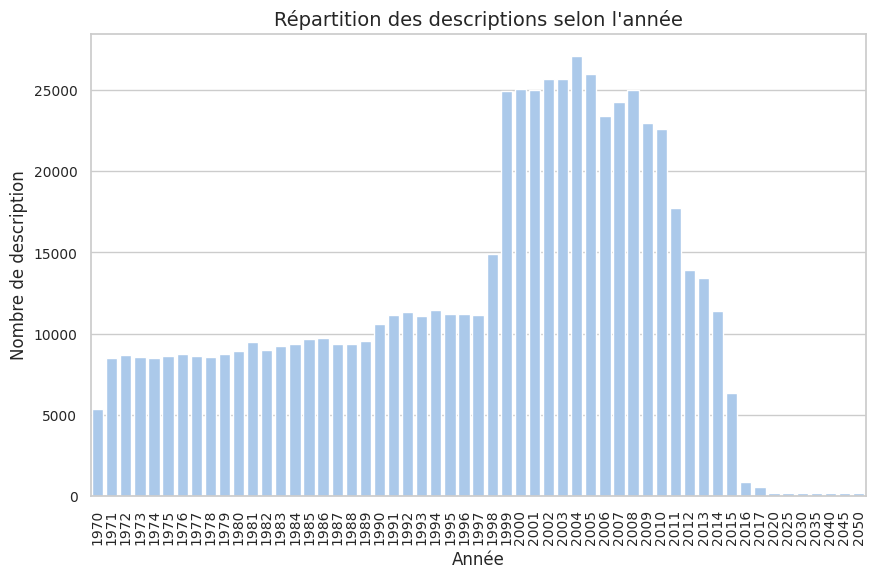

In [106]:
# Voyons la répartition des données selon l'année

plt.figure(figsize = (10, 6))

sns.set_theme(style = 'whitegrid', palette = 'pastel')
sns.countplot(data = foot_note, x = 'Year')

plt.ylabel("Nombre de description", fontsize = 12)
plt.xlabel("Année", fontsize = 12)
plt.yticks(size = 10)
plt.xticks(rotation = 90, size = 10)
plt.title("Répartition des descriptions selon l'année", fontsize = 14)

plt.show()

Nous distinguons 3 groupes :

- Avant 1998, il y a légèrement moins de 10 000 descriptions.
- Entre 1999 et 2010, le nombre de descriptions a été multiplié par 2,5
- Après 2011, le nombre de descriptions diminue progressivement, avec très peu de descriptions pour les données projetées à partir de 2020

La répartition de ces résultats est cohérente avec l'analyse exploratoire des données du dataset data.

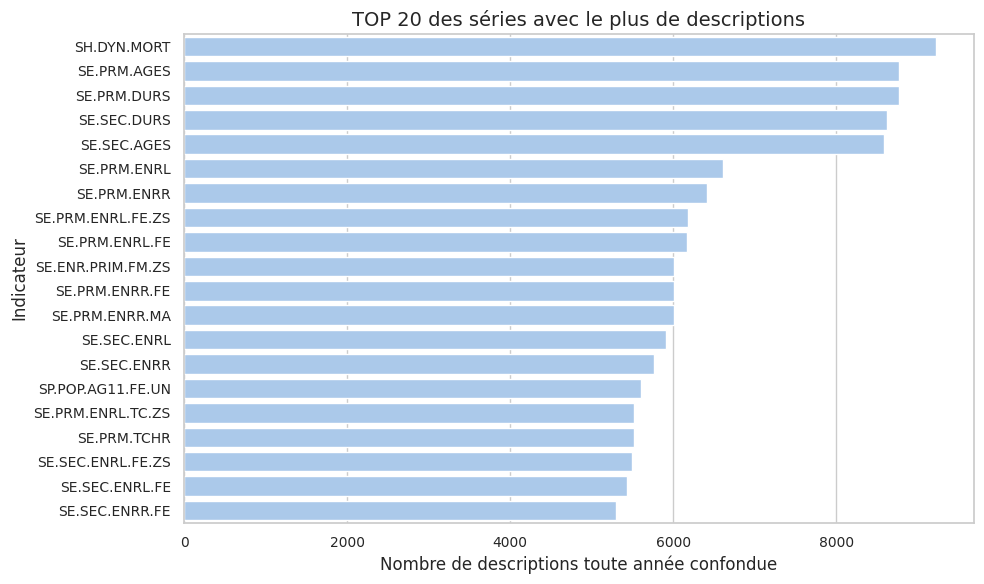

In [107]:
# Voyons les series qui ont le plus de descriptions disponibles

plt.figure(figsize = (10, 6))
top_20_series = foot_note.groupby('SeriesCode').count().sort_values(by = ['CountryCode'], ascending = False)[:20]
top_20_series.reset_index(inplace = True)

sns.set_theme(style = 'whitegrid', palette = 'pastel')
sns.barplot(data = top_20_series, y = 'SeriesCode', x = 'CountryCode')

plt.xlabel("Nombre de descriptions toute année confondue", fontsize = 12)
plt.ylabel("Indicateur", fontsize = 12)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.title("TOP 20 des séries avec le plus de descriptions", fontsize = 14)
plt.tight_layout()

plt.show()

Parmi le top 20 des indicateurs, on trouve l'acronyme SE (Social Education) et SP (Social Population), ainsi que SEC (Secondaire), PRM (Primaire), et POP (Population). Ce sont tous des
 thématiques d'indicateurs potentiellement intéressants pour notre étude.

Étant donné qu'ils sont du même ordre de grandeur, il est difficile de tirer d'autres conclusions basées uniquement sur cette information.

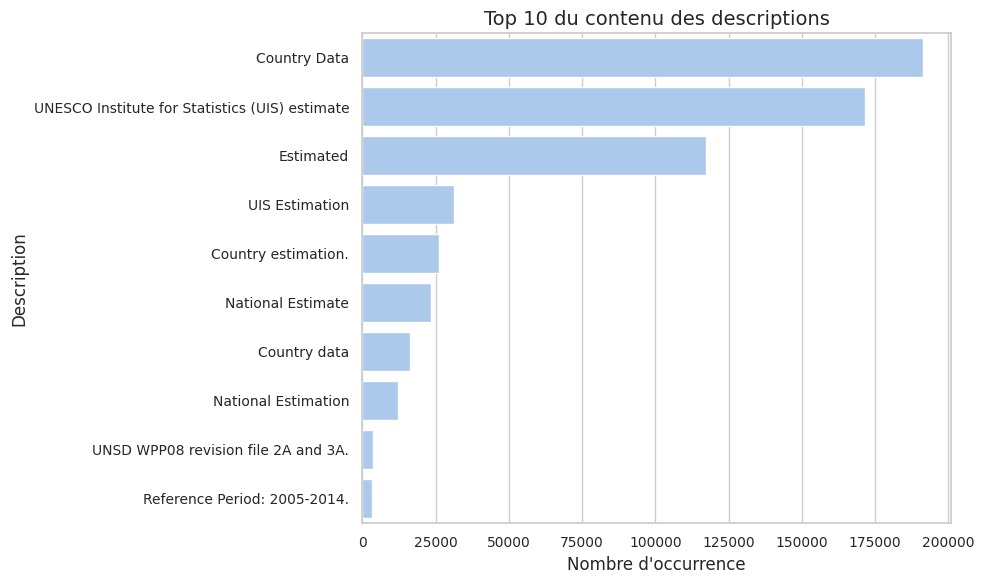

In [108]:
# Déterminons les descriptions les plus présents dans le jeu de données

top_10_description = foot_note.groupby('DESCRIPTION').count().sort_values(by = ['CountryCode'], ascending = False)[:10]
top_10_description.reset_index(inplace = True)

plt.figure(figsize = (10, 6))
sns.set_theme(style = 'whitegrid', palette = 'pastel')
sns.barplot(data = top_10_description.loc[:, ['DESCRIPTION', 'CountryCode']], y = 'DESCRIPTION', x = 'CountryCode')

plt.xlabel("Nombre d'occurrence", fontsize = 12)
plt.ylabel("Description", fontsize = 12)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.title("Top 10 du contenu des descriptions", fontsize = 14)
plt.tight_layout()

plt.show()

Trois sources de descriptions se distinguent particulièrement : "Country Data", "UNESCO Institute for Statistics (UIS) estimate" et "Estimated".

Cela suggère que les méthodes utilisées pour calculer les indicateurs sont relativement homogènes, offrant ainsi une base de données comparables et cohérentes.

---

**Bilan**

Le dataset analysé est complet et exempt de doublons. Néanmoins, malgré la qualité des données, les informations contenues dans ce dataset ne semblent pas apporter de valeur ajoutée significative pour les objectifs spécifiques de notre analyse.

## B. Dataset Country Series

In [109]:
# Valeurs manquantes

print("NOMBRE DE VALEURS MANQUANTES :\n", country_series.isna().sum(), sep='', end='\n\n')

NOMBRE DE VALEURS MANQUANTES :
CountryCode      0
SeriesCode       0
DESCRIPTION      0
Unnamed: 3     613
dtype: int64



In [110]:
# Doublons

duplicates = country_series.duplicated(subset = ['CountryCode', 'SeriesCode'])
per_duplicates = percentage_isna(duplicates)
print("% DE DOUBLONS (VARIABLES : ['CountryCode', 'SeriesCode']): ", per_duplicates, sep='', end='\n\n')

% DE DOUBLONS (VARIABLES : ['CountryCode', 'SeriesCode']): 0.0



Le dataset country_series est complet. Il n'y a aucune donnée manquante, à l'exception de la colonne vide Unnamed, ni de doublons.

---

Graphiques

Je vais proposer 2 représentations graphiques des données disponibles dans le dataset country_series :

1. Une première représentation permet de visualiser, pour chacun des 21 indicateurs, combien de pays ont une source de données renseignée.
2. Une seconde représentation montre le top 10 des bases de données les plus utilisées.

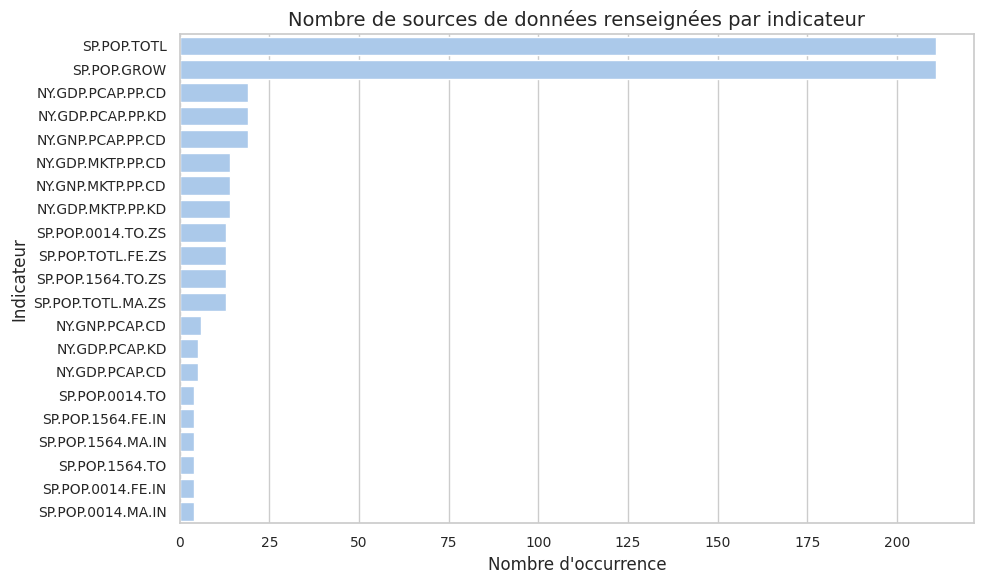

In [111]:
# Voyons le nombre de pays possédant une description par série (21 au total)

plt.figure(figsize = (10, 6))
top_50_series = country_series.groupby('SeriesCode').count().sort_values(by = ['CountryCode'], ascending = False)
top_50_series.reset_index(inplace = True)

sns.set_theme(style = 'whitegrid', palette = 'pastel')
sns.barplot(data = top_50_series, y = 'SeriesCode', x = 'CountryCode')

plt.xlabel("Nombre d'occurrence", fontsize = 12)
plt.ylabel("Indicateur", fontsize = 12)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.title("Nombre de sources de données renseignées par indicateur", fontsize = 14)
plt.tight_layout()

plt.show()

D'après ce graphique, pour tous les pays, les bases de données utilisées pour les deux indicateurs de population, SP.POP.TOTL (population totale) et SP.POP.GROW (taux de croissance de la population), sont connues. Cette observation est attendue, car la mesure de la population totale et de sa croissance est souvent une donnée récurrente et déterminée par de grandes organisations.

Concernant les autres indicateurs, la base de données utilisée est connue pour moins de 25 pays. Cela inclut le PIB (ou GDP) ainsi que d'autres mesures de population.

On notera également que si un indicateur est mentionné pour 42 pays, cela implique indirectement que pour environ 200 pays (en supposant un total de 242 pays), aucune information n'est disponible pour cet indicateur. Bien que le dataset soit considéré comme complet, cette situation révèle l'absence d'information pour de nombreux pays.

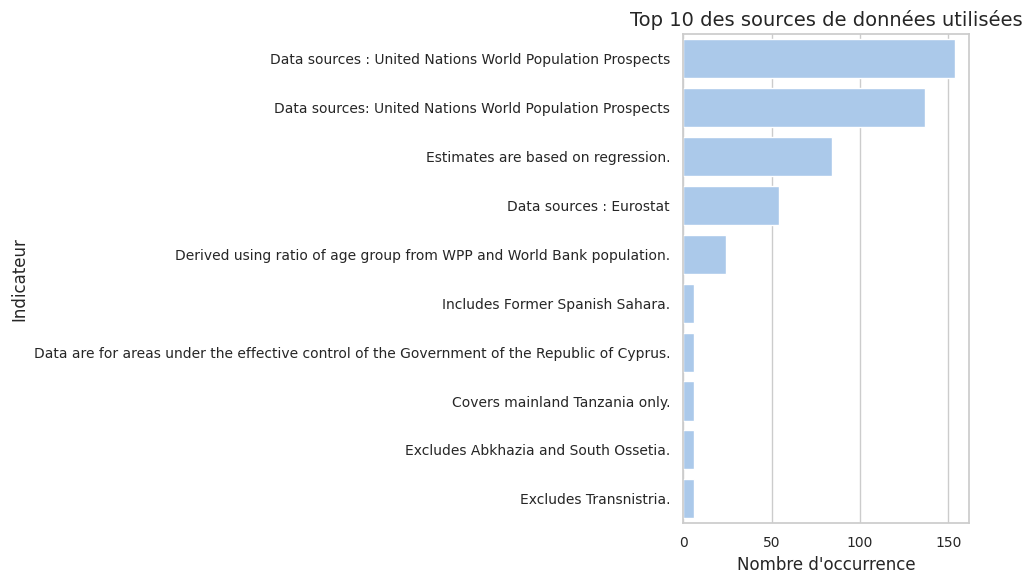

In [112]:
# Déterminons le top 10 des sources de données les plus utilisée dans le jeu de données

top_10_description = country_series.groupby('DESCRIPTION').count().sort_values(by = ['CountryCode'], ascending = False)[:10]
top_10_description.reset_index(inplace=True)

plt.figure(figsize = (10, 6))

sns.set_theme(style = 'whitegrid', palette = 'pastel')
sns.barplot(data = top_10_description.loc[:, ['DESCRIPTION', 'CountryCode']], y = 'DESCRIPTION', x = 'CountryCode')

plt.xlabel("Nombre d'occurrence", fontsize = 12)
plt.ylabel("Indicateur", fontsize = 12)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.title("Top 10 des sources de données utilisées", fontsize = 14)
plt.tight_layout()

plt.show()

La source de données principale est celle fournie par l'organisme 'Population Division of the Department of Economic and Social Affairs of the United Nations Secretariat', qui se présente sous le nom de 'United Nations World Population Prospects'. Il y a également une source de données secondaire issue de l'Eurostat.

Les données issues d'estimations basées sur des régressions sont nombreuses et sont probablement liées aux années 2020 à 2100.

Globalement, les données des indicateurs proviennent de sources fiables.

---
**Bilan**

Ce dataset est propre : il n'y a aucune valeur manquante et aucune ligne dupliquée.

Les sources de données sont restreintes, ce qui rend pertinente la comparaison des valeurs entre les pays.

Cependant, ce dataset ne contient pas de variables qui soient d'un intérêt particulier pour notre étude.

## C. Dataset Country

VALEURS MANQUANTES :
                                                    NB      %
Unnamed: 31                                        241  100.0
National accounts reference year                   209   87.0
Alternative conversion factor                      194   80.0
Other groups                                       183   76.0
Latest industrial data                             134   56.0
Vital registration complete                        130   54.0
External debt Reporting status                     117   49.0
Latest household survey                            100   41.0
Latest agricultural census                          99   41.0
Lending category                                    97   40.0
PPP survey year                                     96   40.0
Special Notes                                       96   40.0
Source of most recent Income and expenditure data   81   34.0
Government Accounting concept                       80   33.0
Latest water withdrawal data                     

Text(0.5, 1.0, 'Matrice des valeurs manquantes \n')

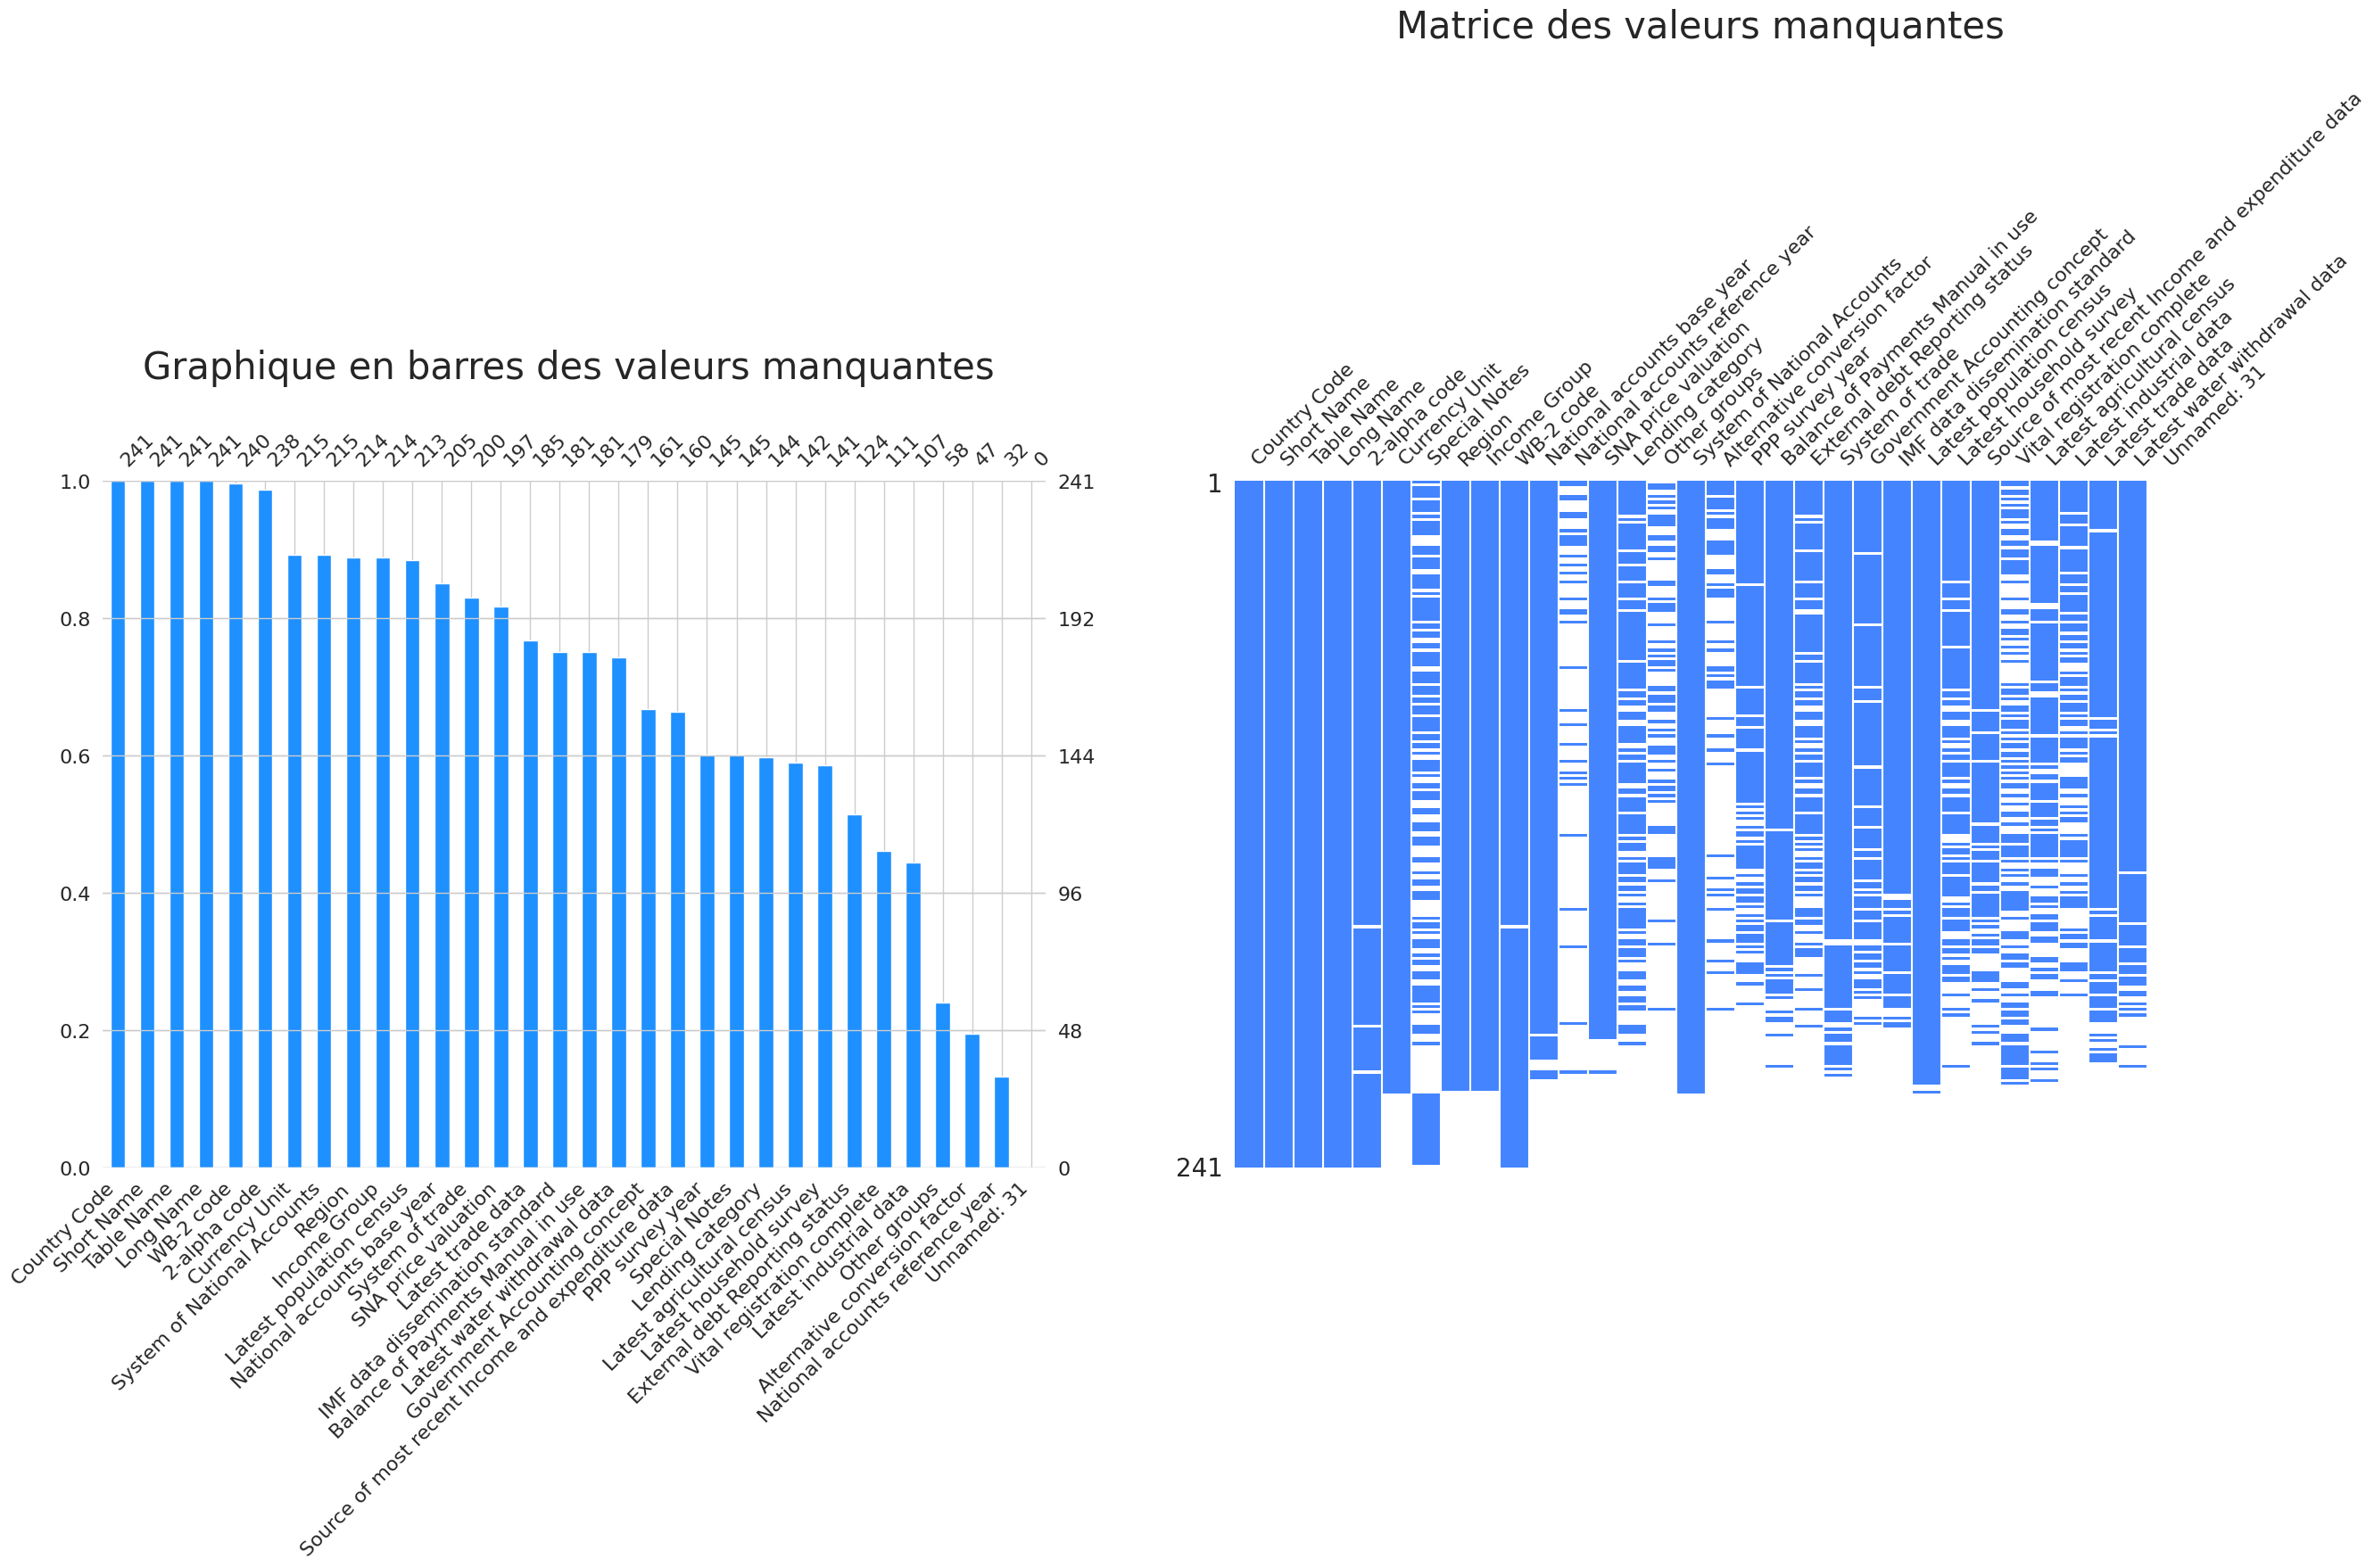

In [113]:
# Valeurs manquantes

missing_values_count = country.isna().sum()
missing_values_percent = round(country.isna().mean() * 100, 0)
missing_data = pd.concat([missing_values_count, missing_values_percent], axis = 1)
missing_data.columns = ['NB', '%']
print("VALEURS MANQUANTES :\n", missing_data.sort_values(by = '%', ascending = False ), sep='', end='\n\n')


# Représentons graphiquement les données manquantes

f, axes = plt.subplots(1,2, figsize=(30, 10))

msno.bar(country,
         color="dodgerblue",
         sort="descending",
         ax = axes[0]
        ).set_title("Graphique en barres des valeurs manquantes \n", fontsize = 30)

msno.matrix(country,
            color=(0.27, 0.52, 1.0),
            sort="descending",
            sparkline = False,
            ax = axes[1]
           ).set_title("Matrice des valeurs manquantes \n", fontsize = 30)

In [114]:
print('nombre de valeurs manquantes total :', missing_data['NB'].sum(axis=0))

nombre de valeurs manquantes total : 2354


Le dataset contient quatre variables avec plus de 75 % de données manquantes : Unnamed: 31, National accounts reference year, Alternative conversion factor, et Other groups.

Les variables des codes des pays et des noms des pays sont complètes.

Enfin, il y a 11 % de données manquantes pour les régions et les groupes économiques.

---

L'un des objectifs confiés par la startup est de déterminer des ordres de grandeurs des indicateurs pour les différentes zones géographiques et pays du monde.

Nous avons donc besoin des informations sur les pays, les régions, et les groupes économiques. Ces données, ne présentant pas un nombre élevé de données manquantes, sont exploitables.

La sélection des variables pour notre étude comprend :

- Country Code
- Short Name
- Region
- Income Group


Ces variables ont été choisies car elles permettent d'identifier clairement les pays et de les classer selon des critères géographiques et économiques pertinents pour notre analyse.

---

Nous allons maintenant explorer à quoi correspondent les 11 % de données manquantes pour les régions et les groupes économiques.

In [115]:
# L'analyse des données manquantes a montré qu'il manquait 11% des données de régions et de groupes économiques
# Nous allons vérifier s'il existe un lien entre les valeurs manquantes de ces 2 variables

region_count = country.loc[country['Region'] == 'NaN', 'Country Code'].count()
income_group_count = country.loc[country['Income Group'] == 'NaN', 'Country Code'].count()
both_count = country.loc[(country['Region'] == 'NaN') & (country['Income Group'] == 'NaN'), 'Country Code'].count()

if (region_count == income_group_count == both_count) :
  print("Quand la region vaut NaN, le groupe économique vaut NaN aussi")
else :
  print("Quand la region vaut NaN, le groupe économique ne vaut pas NaN ou vice versa")

Quand la region vaut NaN, le groupe économique vaut NaN aussi


In [116]:
# Nous allons observer les pays concernés

print(country.loc[country['Region'] == 'NaN', 'Short Name'])

Series([], Name: Short Name, dtype: object)


Les valeurs manquantes correspondent à des agrégats de données. Cela explique pourquoi il y a des données manquantes pour ces variables.

In [117]:
# Doublons

duplicates = country.duplicated(subset = None)
per_duplicates = percentage_isna(duplicates)
print("% DE DOUBLONS :", per_duplicates, sep='', end='\n\n')

% DE DOUBLONS :0.0



Il n'y a aucun doublon dans le dataset.

---
Dans la suite :

Nous allons regrouper les pays selon leur groupe d'appartenance :
- Tout d'abord, selon la région
- Ensuite, selon le groupe d'appartenance économique
- Et finalement, nous afficherons les deux précédents graphiques dans un seul graphique pour une comparaison directe

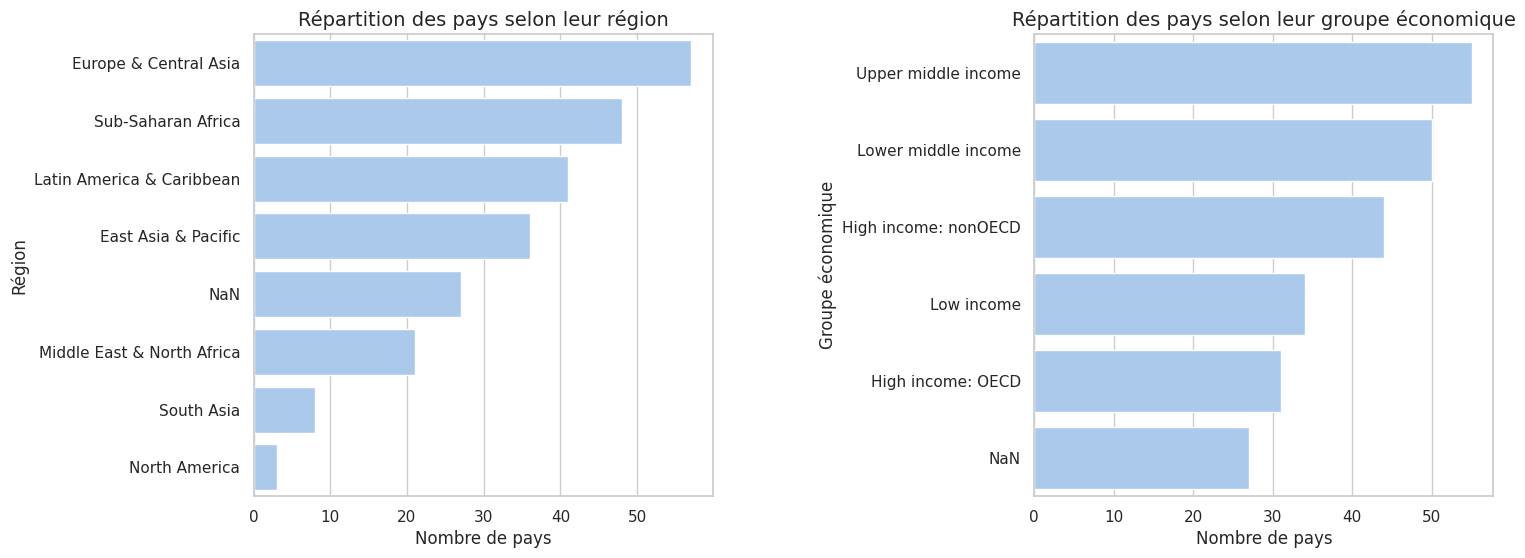

In [118]:
# Inclure les valeurs manquantes pour avoir tous les pays

country['Region'] = country['Region'].fillna('NaN')
country['Income Group'] = country['Income Group'].fillna('NaN')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Premier graphique - Régions

regions_sorted = country.groupby('Region').count().sort_values(by=['Country Code'], ascending = False)
regions_sorted.reset_index(inplace = True)
sns.barplot(data=regions_sorted, y = 'Region', x = 'Country Code', ax = axes[0])
axes[0].set_xlabel("Nombre de pays", fontsize = 12)
axes[0].set_ylabel("Région", fontsize = 12)
axes[0].set_title("Répartition des pays selon leur région", fontsize = 14)

# Deuxième graphique - Groupes de revenus

group_sorted = country.groupby('Income Group').count().sort_values(by=['Country Code'], ascending = False)
group_sorted.reset_index(inplace = True)
sns.barplot(data=group_sorted, y = 'Income Group', x = 'Country Code', ax = axes[1])
axes[1].set_xlabel("Nombre de pays", fontsize = 12)
axes[1].set_ylabel("Groupe économique", fontsize = 12)
axes[1].set_title("Répartition des pays selon leur groupe économique", fontsize = 14)

plt.subplots_adjust(wspace = 0.7)
plt.show()

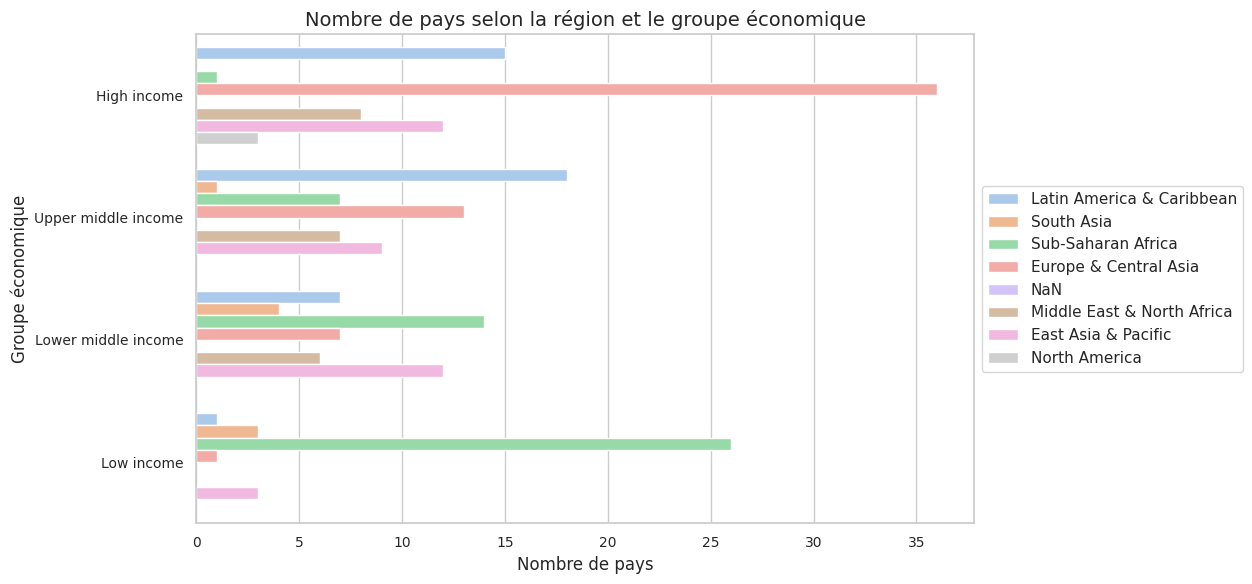

In [119]:
# Regrouper les pays High income: OECD et High income: NonOECD en High income

country_one_high_income = country
country_one_high_income.loc[((country_one_high_income['Income Group'] == 'High income: OECD') | (country_one_high_income['Income Group'] == 'High income: nonOECD')), 'Income Group'] = 'High income'


# 3e représentation graphique : Région et Groupes de revenus
plt.figure(figsize = (10,6))

sns.countplot(y = 'Income Group', hue = 'Region', data = country_one_high_income, orient = 'h',
                   order=['High income', 'Upper middle income', 'Lower middle income', 'Low income'])

plt.xlabel("Nombre de pays", fontsize = 12)
plt.ylabel("Groupe économique", fontsize = 12)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.title("Nombre de pays selon la région et le groupe économique", fontsize = 14)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

**Graphique sur la répartition des pays selon les régions** :

Quatre zones géographiques comptent plus de 35 pays : l'Europe et l'Asie Centrale, l'Afrique subsaharienne, l'Amérique Latine et les Caraïbes, et l'Asie de l'Est et le Pacifique.

L'Amérique du Nord ne compte que trois pays : les Bermudes, le Canada et les États-Unis.

La répartition des pays dans les zones géographiques semble logique, reflétant le découpage plus fin des pays en Europe par rapport à l'Amérique du Nord, où la superficie des pays est généralement plus grande.

La différence de superficie et l'absence d'indication sur la richesse des pays rendent difficile de tirer davantage d'informations de ce graphique.

---

**Graphique sur la répartition des pays selon les groupes économiques** :

Les cinq groupes économiques sont bien représentés, avec chaque groupe comptant entre 30 et 60 pays. Néanmoins, en regroupant les pays des groupes 'High income: OECD' et 'High income: non-OECD', ce groupe économique rassemble le plus grand nombre de pays, indiquant un potentiel élevé (High Income).

---

**Graphique sur la répartition des pays selon les régions et les groupes économiques** :

Ce graphique combine les informations précédemment présentées, illustrant la répartition régionale des pays au sein d'un groupe économique donné.

Sans surprise, dans le groupe économique High Income, ce sont les régions du monde où les pays sont les plus développés et en forte croissance qui sont majoritaire, dont l'Europe et l'Asie centrale, l'Amérique Latine et le Caraïbes etl'Amérique du nord.

Deux tendances inverses sont observées :

- Plus le groupe économique présente un revenu élevé, plus il y a de pays de l'Europe et de l'Asie Centrale.
- À l'inverse, plus le revenu du groupe économique est élevé, moins il y a de pays de la région de l'Afrique Subsaharienne.

Les pays de l'Amérique Latine et des Caraïbes semblent prometteurs, mais il est prématuré de tirer des conclusions définitives à ce stade.

---
**Bilan**

Il n'y a aucun doublon, mais certaines valeurs manquent. Néanmoins, le dataset est pleinement exploitable. Les variables clés, telles que le code du pays, le nom du pays, et les groupes d'appartenance, sont complètes pour chaque pays.

L'Europe et l'Asie Centrale, l'Amérique Latine et les Caraïbes, ainsi que l'Amérique du Nord, sont identifiées comme des régions à fort potentiel, compte tenu de leur nombre et de leur appartenance à des groupes économiques à revenu élevé.



## D. Dataset Data

VALEURS MANQUANTES :
                    NB      %
Unnamed: 69     886930  100.0
2017            886787  100.0
2016            870470   98.0
1978            849354   96.0
1989            849390   96.0
...                ...    ...
2010            644488   73.0
Country Code         0    0.0
Indicator Code       0    0.0
Indicator Name       0    0.0
Country Name         0    0.0

[70 rows x 2 columns]



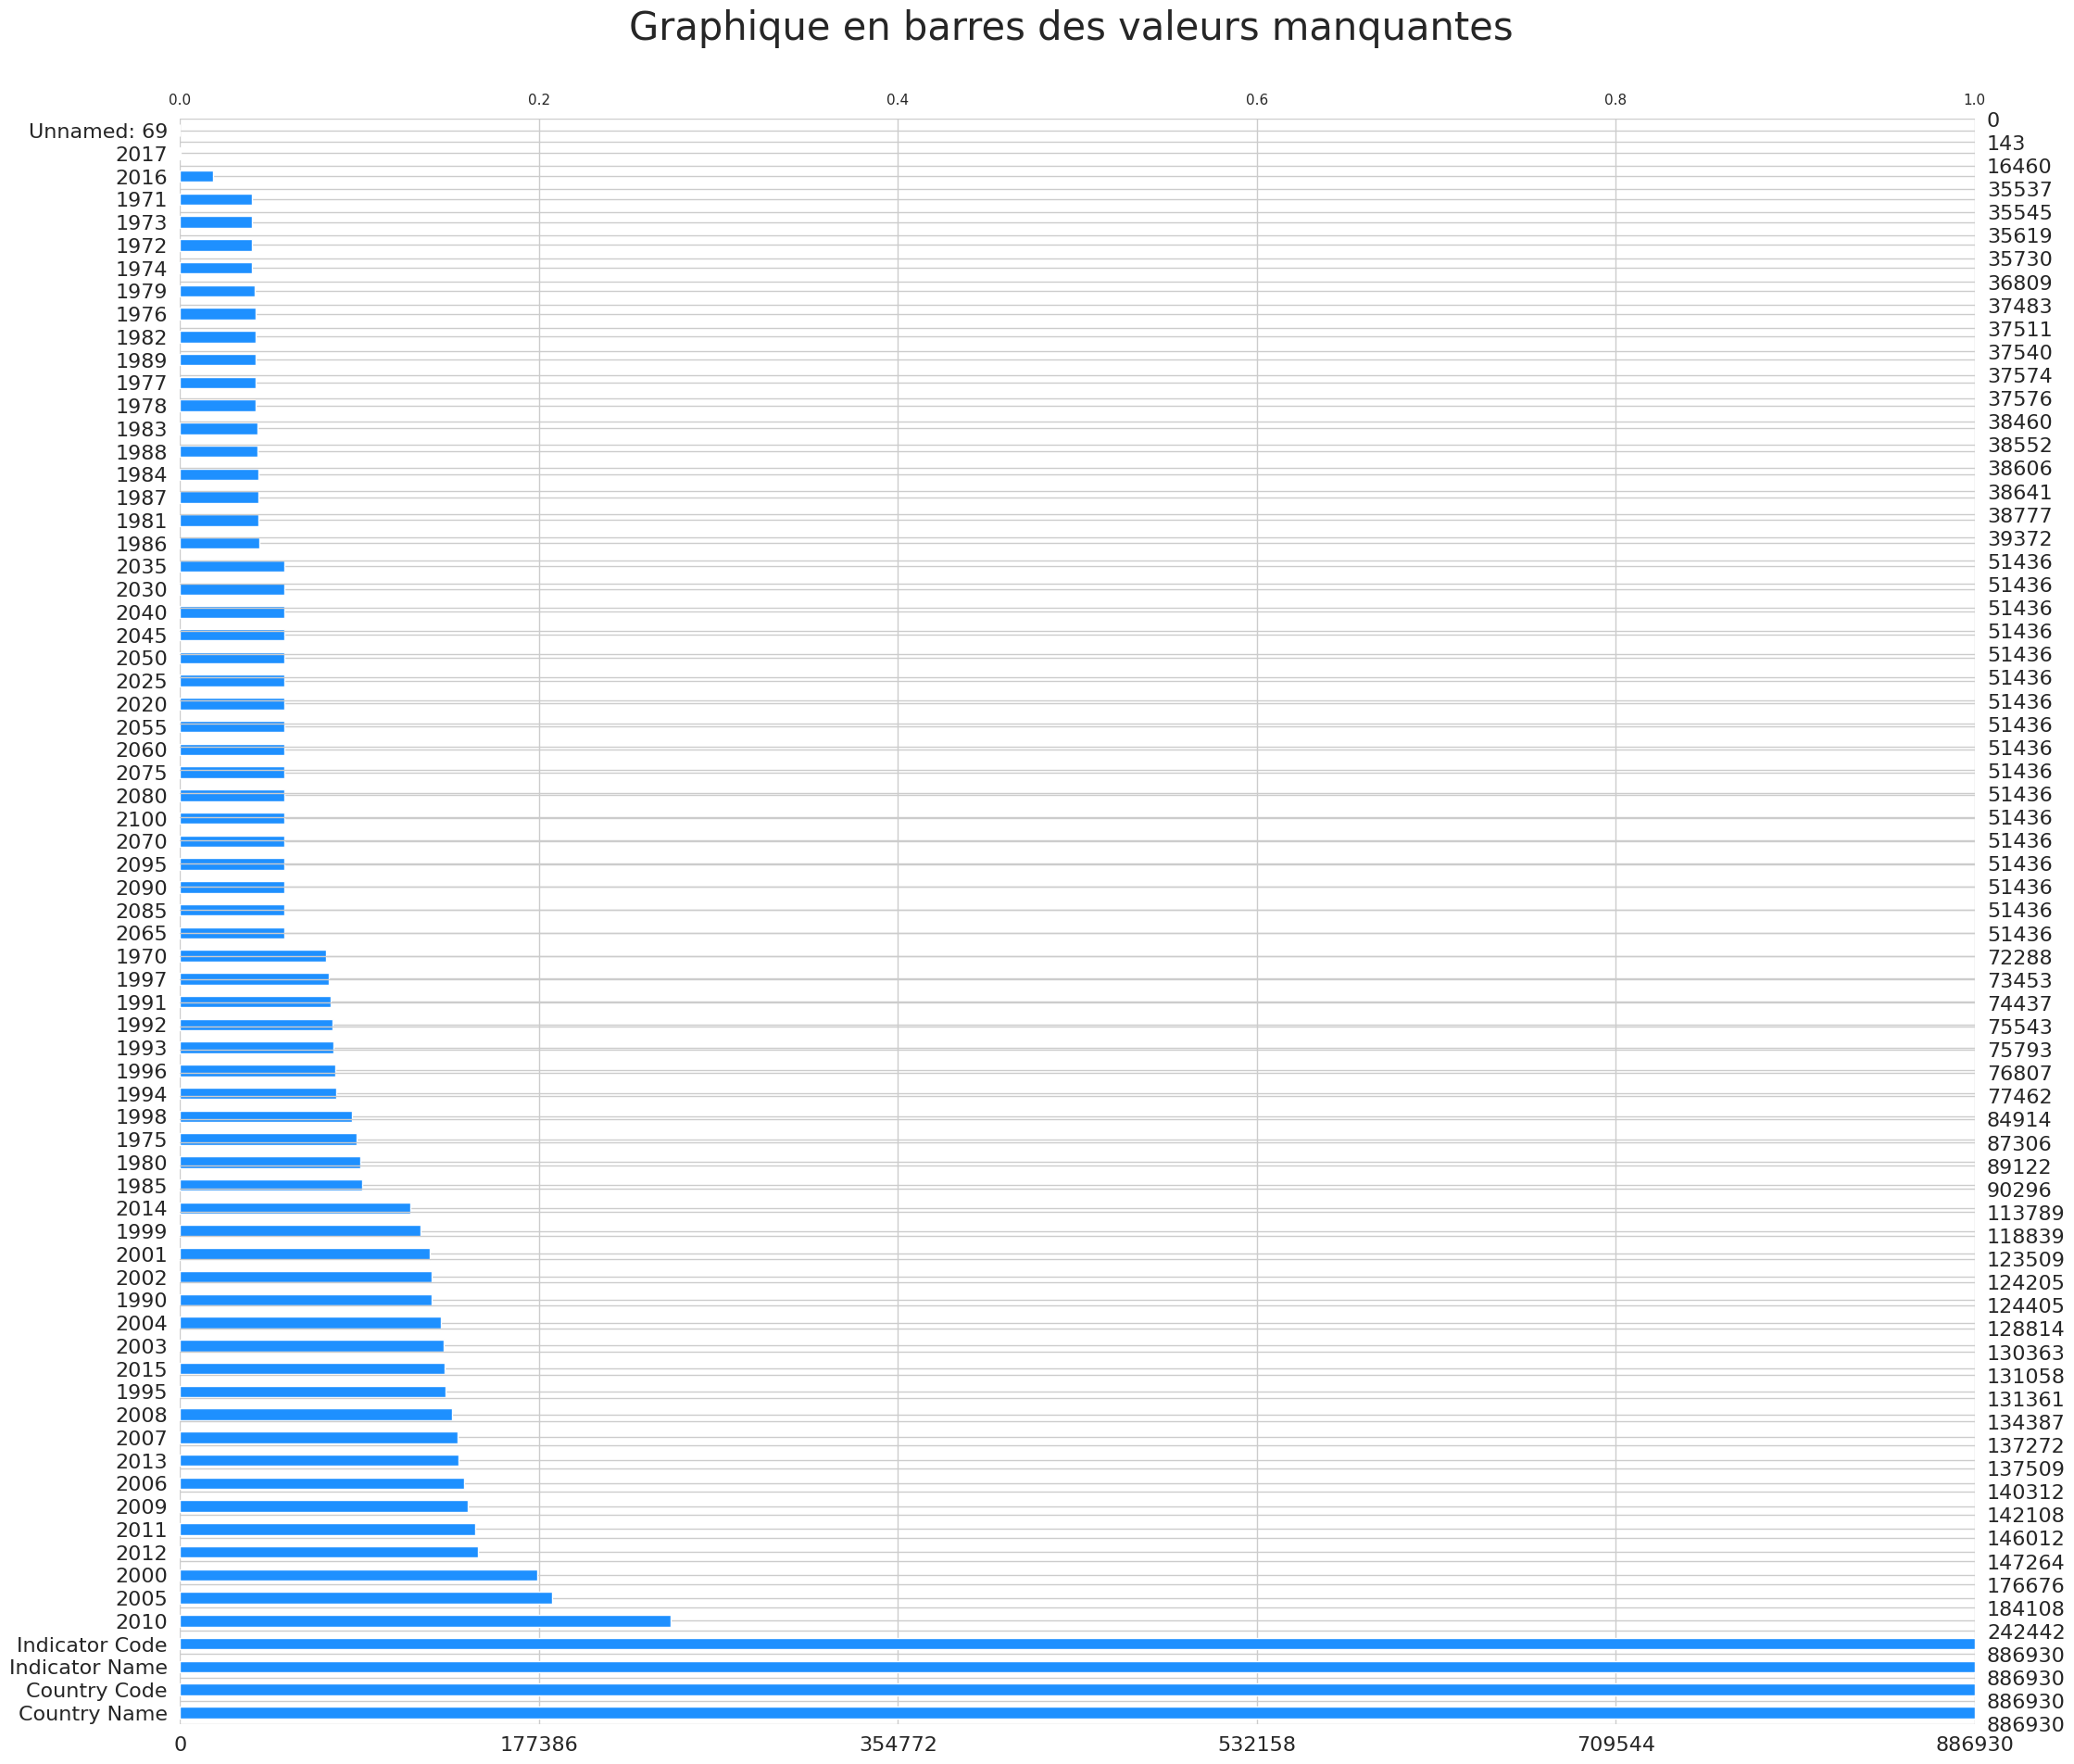

In [120]:
# Valeurs manquantes

missing_values_count = data.isna().sum()
missing_values_percent = round(data.isna().mean() * 100, 0)
missing_data = pd.concat([missing_values_count, missing_values_percent], axis = 1)
missing_data.columns = ['NB', '%']
print("VALEURS MANQUANTES :\n", missing_data.sort_values(by = '%', ascending = False ), sep = '', end = '\n\n')


# Représentons graphiquement les données manquantes

plt.figure(figsize=(30, 10))
msno.bar(data,
         color="dodgerblue",
         sort="descending",
        ).set_title("Graphique en barres des valeurs manquantes \n", fontsize = 30)
plt.show()


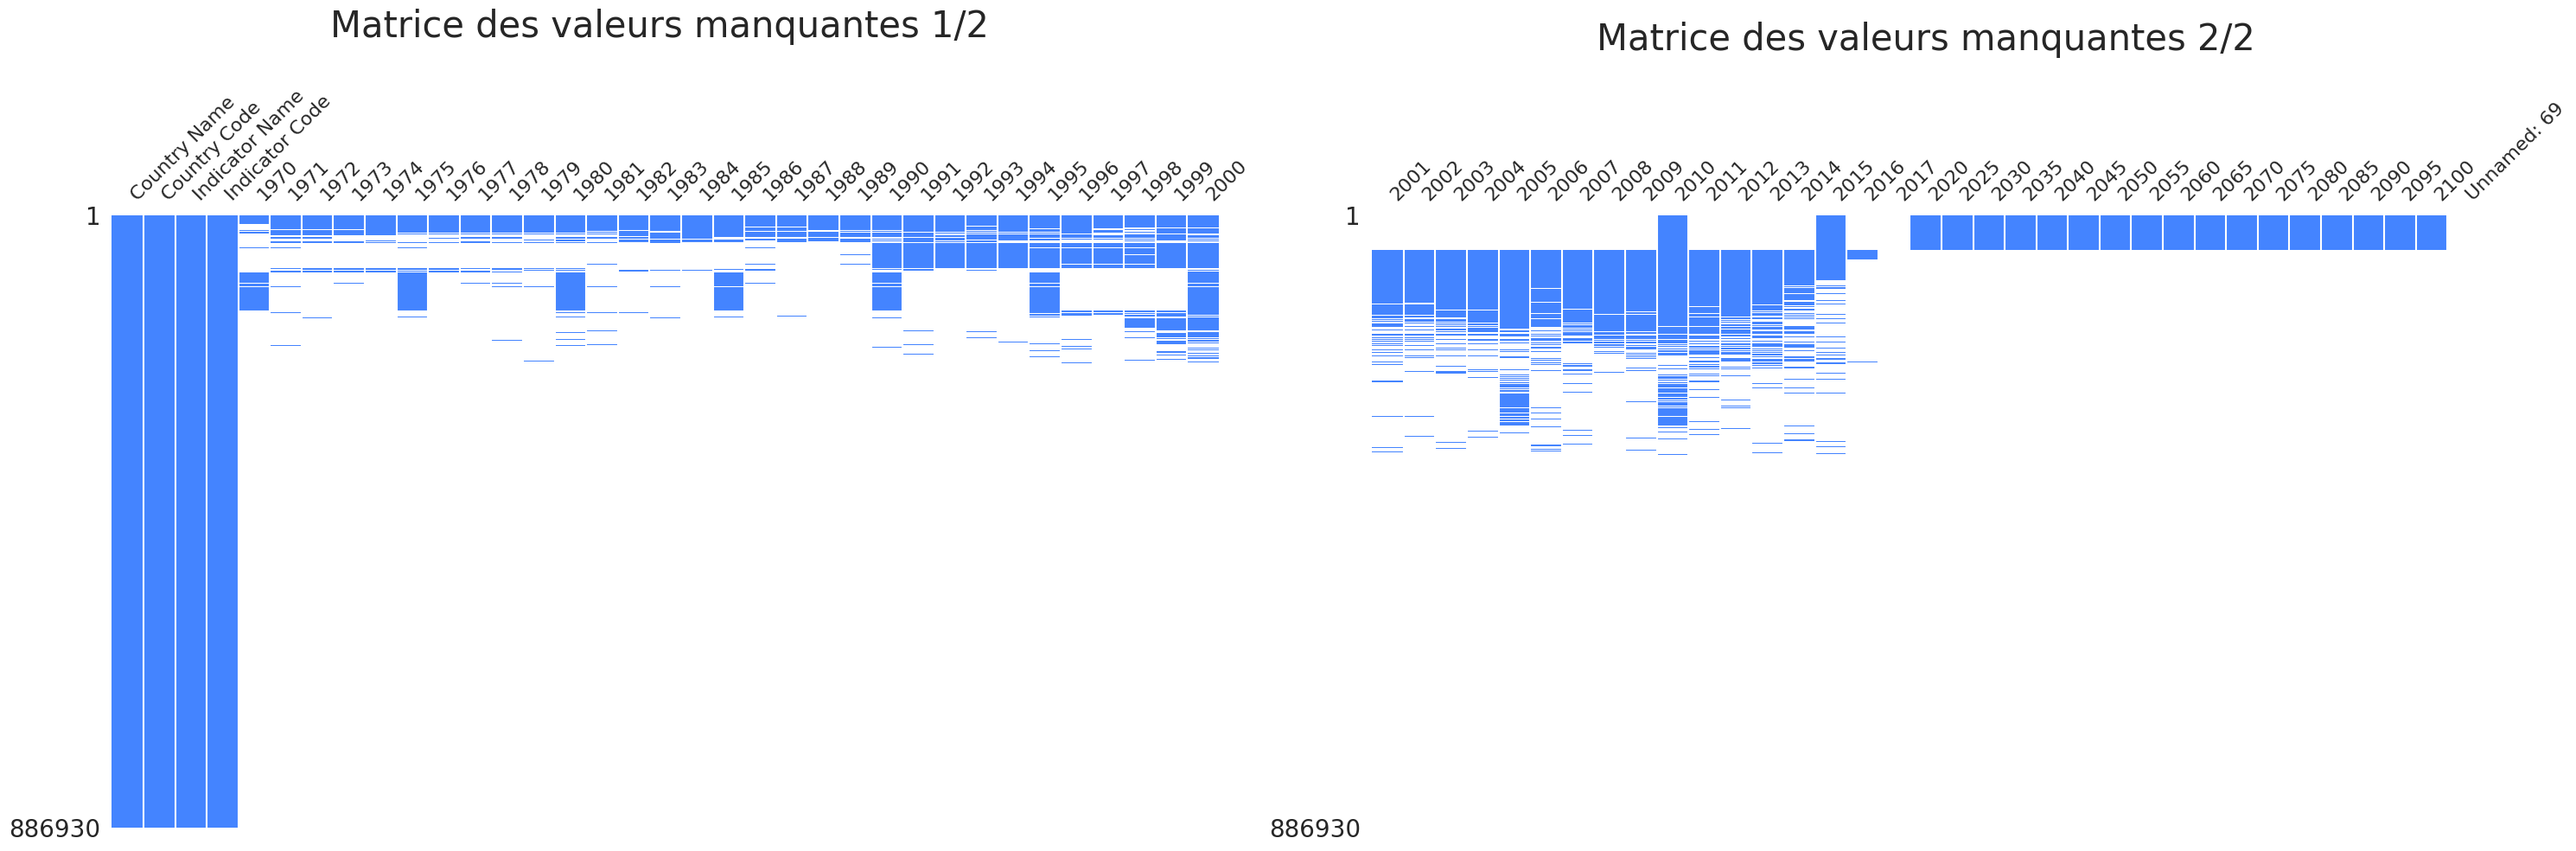

In [121]:
f, axes = plt.subplots(1,2, figsize=(30, 10))
f.subplots_adjust(wspace=0.3)

msno.matrix(data.iloc[:, :35],
         color=(0.27, 0.52, 1.0),
         sort="descending",
         sparkline = False,
         ax = axes[0]
        ).set_title("Matrice des valeurs manquantes 1/2 \n", fontsize = 30)

msno.matrix(data.iloc[:, 35:],
            color=(0.27, 0.52, 1.0),
            sort="descending",
            sparkline = False,
            ax = axes[1]
           ).set_title("Matrice des valeurs manquantes 2/2\n", fontsize = 30)

plt.tight_layout()
plt.show()


Les données essentielles, à savoir le code pays, le nom du pays, le nom de l'indicateur, et le code de l'indicateur, sont complètes.

Cependant, pour ce qui est des données annuelles, plus de 73% des informations manquent pour chaque année. Néanmoins, ce résultat doit être mis en perspective, car le dataset contient 886 930 enregistrements. Par exemple, même si 2016 présente 98% de données manquantes, il reste tout de même 16 460 enregistrements disponibles.

La colonne de 2017 ne contient que 143 enregistrements. En comparaison avec 2016, les données sont trop peu nombreuses pour être considérées comme exploitables.

---

**SELECTION DES VARIABLES** :

Notre objectif est de déterminer les pays ayant le plus de potentiel pour la startup :

- Nous avons donc besoin des données les plus récentes. Une donnée datant de plus de 10 ans, par exemple, est peu pertinente

=> Nous ne prendrons pas en compte les données antérieures à 2010.

- De plus, les données prévisionnelles ne sont pas pertinentes pour déterminer le potentiel d'un pays, car elles sont par définition prévisionnelles, sans oublier qu'elles comportent des données manquantes

Le graphique des valeurs manquantes manque de précision sur le nombre exact de données disponibles pour une année donnée, car l'échelle s'adapte aux variables dont les données sont complètes. De plus, il est organisé selon le nombre de valeurs décroissantes, ce qui rend difficile la comparaison des valeurs disponibles pour des années consécutives.

Traçons un graphique pour visualiser les données disponibles par année.

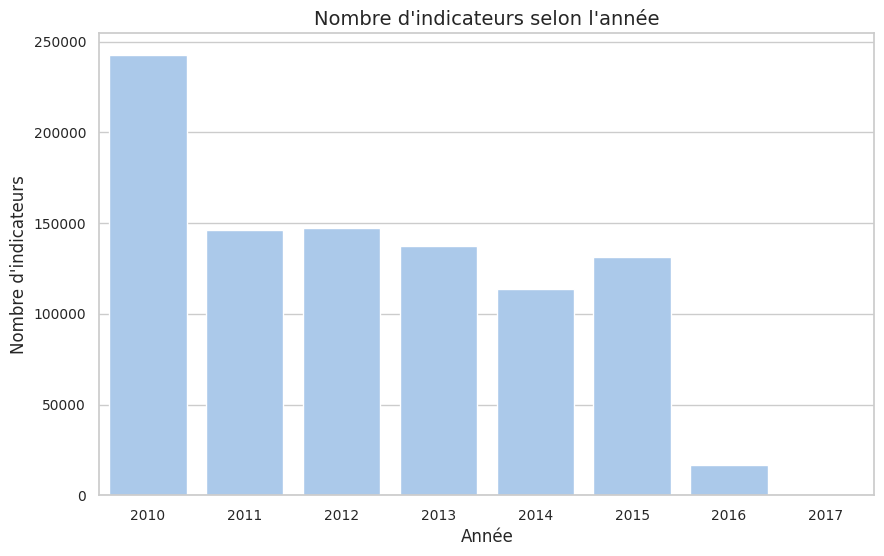

In [122]:
# Représentons graphiquement le nombre d'enregistrements disponibles par an

plt.figure(figsize=(10, 6))

sns.set_theme(style='whitegrid', palette='pastel')
group_indicator = data.loc[:, ['Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']].groupby('Indicator Code').count()

total = group_indicator.sum() # output.serie/scalar
total = pd.DataFrame(total).reset_index().rename(columns={'index': 'Year', 0: 'Total'})
sns.barplot(data = total, x='Year', y = 'Total')

plt.xlabel("Année", fontsize=12)
plt.ylabel("Nombre d'indicateurs", fontsize=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.title("Nombre d'indicateurs selon l'année", fontsize=14)

plt.show()

Nous observons une stabilité dans le nombre de données enregistrées entre 2011 et 2015.

Aucune donnée n'est disponible pour 2017, rendant inutile la conservation de cette colonne.

Pour l'analyse, la sélection des données se basera sur la disponibilité de l'information la plus récente. Étant donné que 2016 contient significativement moins de données par rapport aux quatre années précédentes, et que le volume de données disponibles entre 2011 et 2015 est relativement stable, 2016 ne sera pas considéré pour la suite de l'étude.

In [123]:
# Doublons
duplicates = data.duplicated(subset = ['Country Code', 'Indicator Code'])
per_duplicates = percentage_isna(duplicates)
print("% DE DOUBLONS (VARIABLES : ['Country Code', 'Indicator Code']): ", per_duplicates, sep='', end='\n\n')

% DE DOUBLONS (VARIABLES : ['Country Code', 'Indicator Code']): 0.0



Il n'y a aucun doublon.

---
**Bilan**

Malgré le fait qu'il y ait plus de 73% de données manquantes pour toutes les variables années, les informations disponibles pour les années récentes, spécifiquement de 2010 à 2015, sont suffisantes pour permettre une étude approfondie des indicateurs.


## E. Dataset Series

NOMBRE DE VALEURS MANQUANTES :
                                       NB      %
Limitations and exceptions           3651  100.0
Notes from original source           3665  100.0
License Type                         3665  100.0
Related indicators                   3665  100.0
Other web links                      3665  100.0
Development relevance                3662  100.0
General comments                     3651  100.0
Unnamed: 20                          3665  100.0
Unit of measure                      3665  100.0
Aggregation method                   3618   99.0
Statistical concept and methodology  3642   99.0
Periodicity                          3566   97.0
Related source links                 3450   94.0
Base Period                          3351   91.0
Other notes                          3113   85.0
Short definition                     1509   41.0
Topic                                   0    0.0
Source                                  0    0.0
Long definition                       

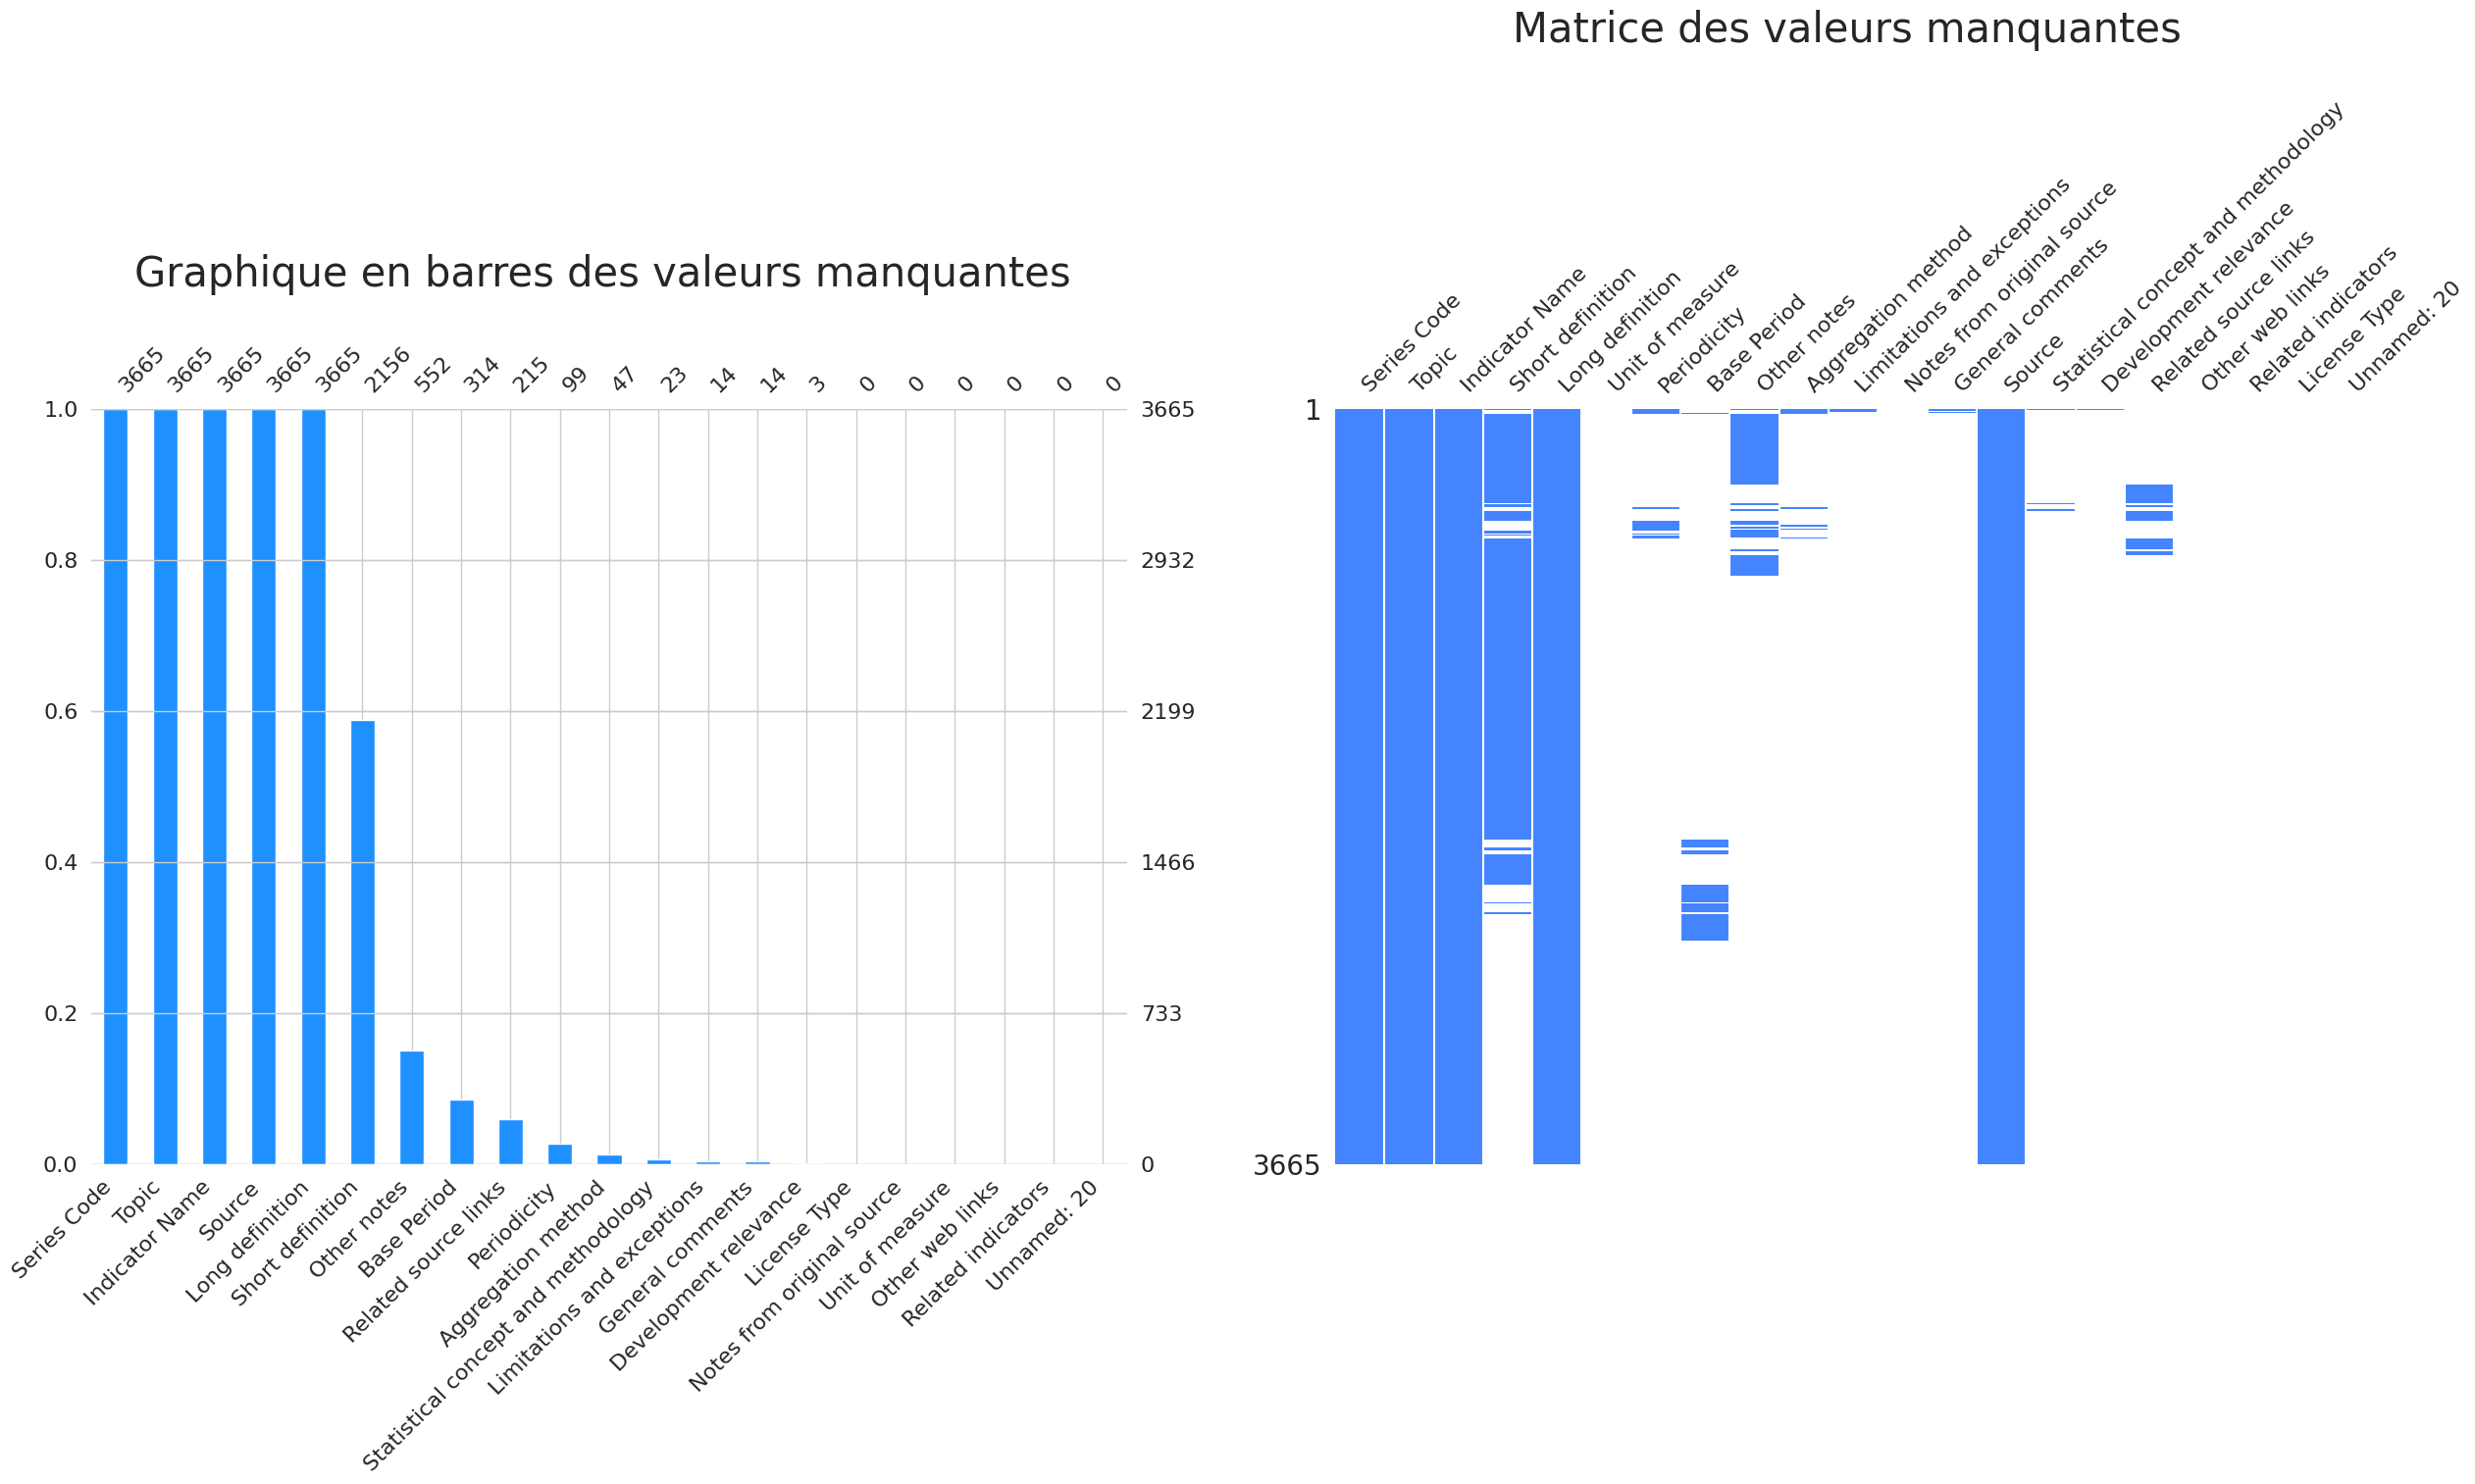

In [124]:
# Valeurs manquantes

missing_values_count = series.isna().sum()
missing_values_percent = round(series.isna().mean() * 100, 0)
missing_series = pd.concat([missing_values_count, missing_values_percent], axis=1)
missing_series.columns = ['NB', '%']
print("NOMBRE DE VALEURS MANQUANTES :\n", missing_series.sort_values(by = '%', ascending = False ), sep='', end='\n\n')

# Représentons graphiquement les données manquantes

f, axes = plt.subplots(1,2, figsize=(30, 10))

msno.bar(series,
         color="dodgerblue",
         sort="descending",
         ax = axes[0]
        ).set_title("Graphique en barres des valeurs manquantes \n", fontsize = 30)

msno.matrix(series,
            color=(0.27, 0.52, 1.0),
            sort="descending",
            sparkline = False,
            ax = axes[1]
           ).set_title("Matrice des valeurs manquantes \n", fontsize = 30)

plt.show()


Parmi les 21 variables analysées, 15 présentent un taux de données manquantes supérieur à 85%. De plus, leur pertinence pour notre étude est limitée. Parmi les 6 variables restantes, nous avons identifié que la variable 'Short definition' est redondante par rapport à 'Long definition'.

Ainsi, nous avons déterminé que 4 variables sont réellement exploitables pour notre analyse. Trois d'entre elles sont cruciales car elles fournissent le nom de l'indicateur, sa définition détaillée, son code (série), ainsi que son thème.

Quant à la variable 'source', elle ne revêt pas d'intérêt particulier pour notre objectif d'étude.

In [125]:
# Doublons

duplicates = series.duplicated(subset = None)
per_duplicates = percentage_isna(duplicates)
print("% DE DOUBLONS :", per_duplicates, sep='', end='\n\n')

% DE DOUBLONS :0.0



Représentons graphiquement les thèmes des indicateurs pour avoir une idée des thématiques disponibles.

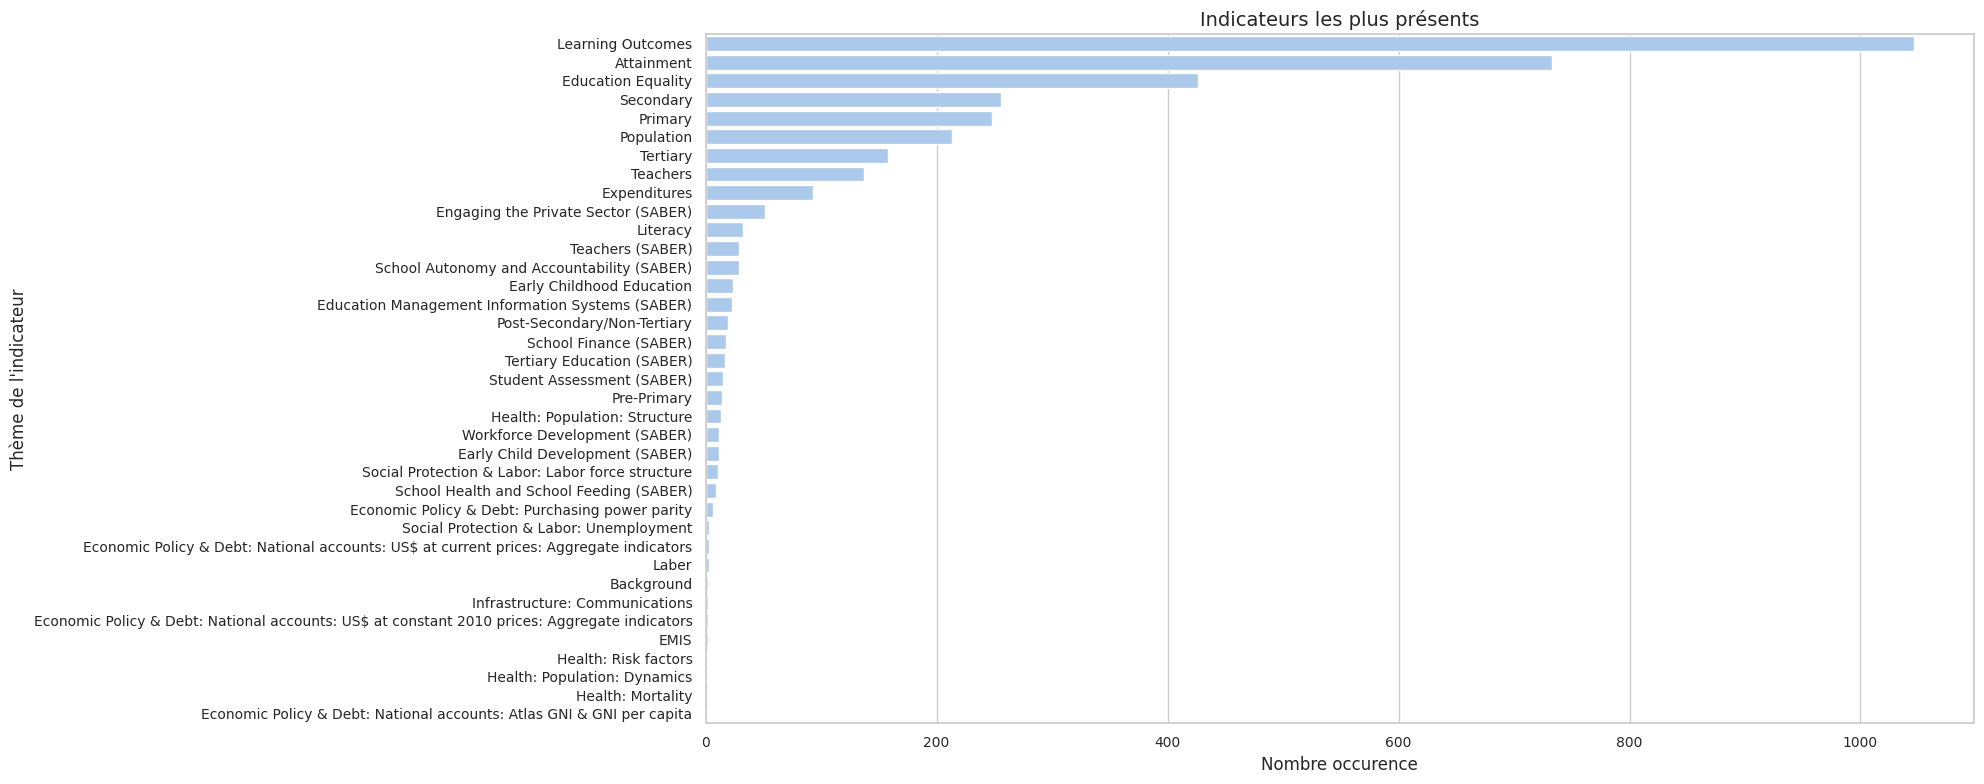

In [126]:
plt.figure(figsize=(20,8))
sns.set_theme(style='whitegrid', palette='pastel')

series_ordered = series.loc[:, ['Topic', 'Series Code']].groupby('Topic').count().reset_index().sort_values(by = 'Series Code', ascending = False)
sns.barplot(data = series_ordered, y = 'Topic', x = 'Series Code')

plt.xlabel("Nombre occurence", fontsize=12)
plt.ylabel("Thème de l'indicateur", fontsize=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.title("Indicateurs les plus présents", fontsize=14)
plt.tight_layout()

plt.show()

Graphiquement, les thèmes "Learning Outcome" et "Attainment" se distinguent nettement, indiquant leur potentiel pour approfondir notre analyse.

**Bilan**

Dans le dataset "series", les variables les plus pertinentes sont celles fournissant des informations détaillées sur les indicateurs, notamment leur nom, leur code et leur description complète. De plus, la variable "Topic" s'avère intéressante pour catégoriser les indicateurs.

## Bilan général

Pour simplifier les datasets et les exploiter, nous avons conservé les données les plus pertinentes dont la qualité est suffisante.

Voici la selection des variables par dataset :
- series : 'Series Code', 'Topic', 'Indicator Name', 'Long definition'  
- data :'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015'
- country: 'Country Code', 'Short Name', 'Long Name', 'Region', 'Income Group'
- country series et foot note : Aucune variable retenue, ces datasets n'apportant pas d'informations cruciales pour notre objectif d'étude

Dans l'ensemble, malgré des données manquantes, celles-ci sont soit négligeables (car non pertinentes pour notre analyse), soit en quantité suffisante pour les années sélectionnées.

In [127]:
# Mise à jour des données

series = series.loc[:, ['Series Code', 'Topic', 'Indicator Name', 'Long definition']]
data_original = data.copy()
data = data.loc[:, ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015']]
country = country.loc[:, ['Country Code', 'Short Name', 'Long Name', 'Region', 'Income Group']]

# **V. Choix des variables définitives et préparation des datasets pour l'analyse**


## A. Choix des indicateurs potentiels

Nous allons sélectionner les années de 2010 à 2015.

Dans un premier temps, nous identifierons les indicateurs pertinents pour notre étude.

Les contenus sont des formations en ligne pour un public de niveau lycée et université.

Nous avons donc besoin de connaitre :
- L'offre et la demande des étudiants
- Le pouvoir d'achat pour acheter notre produit
- La faisabilité : il faut vérifier que le pays possède les moyens technologiques pour visionner les cours en ligne

Pour le choix des indicateurs, nous allons afficher tous les indicateurs disponibles et les sélectionner.

In [128]:
# Choisissons les indicateurs en fonction du nom de l'indicateur

group_series = series['Topic'].unique()

for topic in group_series:
  group_long_def = series.loc[series['Topic'] == topic, 'Indicator Name'].unique()
  print(topic, end='\n\n')
  print(group_long_def, end='\n\n\n\n\n\n')

Attainment

['Barro-Lee: Percentage of female population age 15-19 with no education'
 'Barro-Lee: Percentage of population age 15-19 with no education'
 'Barro-Lee: Percentage of female population age 15+ with no education'
 'Barro-Lee: Percentage of population age 15+ with no education'
 'Barro-Lee: Percentage of female population age 20-24 with no education'
 'Barro-Lee: Percentage of population age 20-24 with no education'
 'Barro-Lee: Percentage of female population age 25-29 with no education'
 'Barro-Lee: Percentage of population age 25-29 with no education'
 'Barro-Lee: Percentage of female population age 25+ with no education'
 'Barro-Lee: Percentage of population age 25+ with no education'
 'Barro-Lee: Percentage of female population age 30-34 with no education'
 'Barro-Lee: Percentage of population age 30-34 with no education'
 'Barro-Lee: Percentage of female population age 35-39 with no education'
 'Barro-Lee: Percentage of population age 35-39 with no education'
 'Barro-L

Tous les indicateurs dans leur catégorie (ou 'Topic') respective ont été affichés.

Ce travail vise à aider une startup de Edtech à déterminer une liste de pays cibles pour développer leur portefeuille client.

Les produits de l'Edtech sont des formations et à destination d'une population de jeunes entre 15 et 24 ans.

Voici les indicateurs potentiels :

- L'offre et la demande des étudiants

Nous avons besoin de connaitre la demande potentielle qui sera représentée par la population entre 15-24 ans (**Population, ages 15-24, total**).

De plus, nous étudierons l'offre actuelle qui sera représentée par le nombre d'inscription dans l'éducation secondaire (**Enrolment in secondary education, both sexes (number)**) et tertiaire (**Enrolment in tertiary education, all programmes, both sexes (number)**).

Nous fusionnerons ces 2 indicateurs pour avoir le nombre d'inscriptions total.


- Le pouvoir d'achat pour acheter notre produit

Nous souhaitons connaitre le pouvoir d'achat des clients au sein d'un pays et pouvoir les comparer entre les pays. Pour cela, on s'appuiera sur le produit intérieur brut basé sur la parité de pouvoir d'achat (**GDP, PPP (current international $)**).

Il est également possible que l'Etat soit le financeur, il est donc intéressant de savoir quel est le budget de l'Etat alloué par étudiant dans le secondaire (**Government expenditure per secondary student (constant PPP$)**) et dans le tertiaire (**Government expenditure per tertiary student (constant PPP\$)**).

Nous fusionnerons ces 2 indicateurs pour avoir le budget alloué pour un étudiant durant ses études supérieures.


- La faisabilité

Enfin, les clients ont besoin de moyens technologiques c'est-à-dire d'internet (**Internet users (per 100 people)**) et de support informatique (**Personal computers (per 100 people)**).

Regardons la description longue de ces indicateurs

In [129]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

chosen_indicator_name = [
'Personal computers (per 100 people)',
'Internet users (per 100 people)',
'GDP, PPP (current international $)',
'Enrolment in tertiary education, all programmes, both sexes (number)',
'Enrolment in secondary education, both sexes (number)',
'Population, ages 15-24, total',
'Government expenditure per secondary student (PPP$)',
'Government expenditure per tertiary student (PPP$)']

chosen_indicator_code = [
'IT.CMP.PCMP.P2',
'IT.NET.USER.P2',
'NY.GDP.MKTP.PP.CD',
'SE.TER.ENRL',
'SE.SEC.ENRL',
'SP.POP.1524.TO.UN',
'UIS.XUNIT.PPP.23.FSGOV',
'UIS.XUNIT.PPP.56.FSGOV']

indicator_def = series.loc[series['Series Code'].isin(chosen_indicator_code), ['Indicator Name', 'Long definition']]
indicator_def.style.set_properties(**{'text-align': 'left'})
print(indicator_def['Long definition'])
print(chosen_indicator_code)

pd.reset_option('all')

610                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Personal computers are self-contained computers designed to be used by a single individual.
611                                                                                      

<ipython-input-129-357ba19ddaec>:31: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option('all')
<ipython-input-129-357ba19ddaec>:31: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option('all')
<ipython-input-129-357ba19ddaec>:31: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option('all')


L'analyse sur la qualité des datasets s'est conclue par l'analyse des données entre 2010 et 2015.

Créons le dataframe de travail en filtrant par les années, et les indicateurs choisis.

## B. Création du dataframe de travail initial

In [130]:
mask_coldata = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015']
mask_colcountry = ['Country Code', 'Region'] #, 'Income Group', 'Other groups'
mask_colseries = ['Series Code', 'Topic', 'Long definition']

working_df = data.loc[data['Indicator Code'].isin(chosen_indicator_code), mask_coldata]
working_df = pd.merge(working_df, country[mask_colcountry], left_on='Country Code', right_on='Country Code', how = 'left')
working_df = pd.merge(working_df, series[mask_colseries], left_on='Indicator Code', right_on='Series Code', how = 'left').drop(columns = 'Series Code')


# Dimension
nRow, nCol  = working_df.shape
print("NB DE LIGNES   :", nRow)
print("NB DE COLONNES :", nCol, end ='\n\n')

# Nom des colonnes
print("LISTE DES COLONNES :", working_df.columns.to_list(), end='\n\n')

NB DE LIGNES   : 1936
NB DE COLONNES : 13

LISTE DES COLONNES : ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015', 'Region', 'Topic', 'Long definition']



Le dataframe de travail est crée, voyons si tous les indicateurs choisis sont exploitables, c'est-à-dire si on dispose de suffisamment de données.

## C. Vérification du nombre de données disponibles par indicateur

In [131]:
# Valeurs manquantes par indicateur

years = ['2015', '2014', '2013', '2012', '2011', '2010']

for indicator in chosen_indicator_code:
  missing_values_count = working_df.loc[working_df['Indicator Code'] == 'indicator', years].isna().sum()
  missing_values_percent = round(working_df.loc[working_df['Indicator Code'] == indicator, years].isna().mean() * 100, 0)
  missing_working_df = pd.concat([missing_values_count, missing_values_percent], axis = 1)
  missing_working_df.columns = ['NB', '%']
  print(f'VALEURS MANQUANTES DE L\'INDICATEUR \'{indicator}\' :\n', missing_working_df.sort_values(by = '%', ascending = False ), sep = '', end = '\n\n')

VALEURS MANQUANTES DE L'INDICATEUR 'IT.CMP.PCMP.P2' :
       NB      %
2015  0.0  100.0
2014  0.0  100.0
2013  0.0  100.0
2012  0.0  100.0
2011  0.0  100.0
2010  0.0  100.0

VALEURS MANQUANTES DE L'INDICATEUR 'IT.NET.USER.P2' :
       NB    %
2015  0.0  8.0
2014  0.0  8.0
2013  0.0  7.0
2012  0.0  6.0
2010  0.0  6.0
2011  0.0  5.0

VALEURS MANQUANTES DE L'INDICATEUR 'NY.GDP.MKTP.PP.CD' :
       NB     %
2015  0.0  15.0
2014  0.0  14.0
2013  0.0  12.0
2012  0.0  12.0
2010  0.0  11.0
2011  0.0  10.0

VALEURS MANQUANTES DE L'INDICATEUR 'SE.TER.ENRL' :
       NB     %
2015  0.0  52.0
2014  0.0  38.0
2013  0.0  36.0
2010  0.0  32.0
2012  0.0  31.0
2011  0.0  31.0

VALEURS MANQUANTES DE L'INDICATEUR 'SE.SEC.ENRL' :
       NB     %
2015  0.0  47.0
2014  0.0  31.0
2013  0.0  31.0
2012  0.0  28.0
2010  0.0  27.0
2011  0.0  25.0

VALEURS MANQUANTES DE L'INDICATEUR 'SP.POP.1524.TO.UN' :
       NB     %
2015  0.0  25.0
2014  0.0  25.0
2013  0.0  25.0
2012  0.0  25.0
2011  0.0  25.0
2010  0.0  25.0

Il n'y a aucune donnée disponible pour l'indicateur "Personal computers (per 100 people)".

Nous allons le supprimer et conserver les autres indicateurs.

In [132]:
# Retirer l'indicateur qui ne contient aucune donnée

chosen_indicator_code.remove('IT.CMP.PCMP.P2')
chosen_indicator_name.remove('Personal computers (per 100 people)')

## D. Préparation des 2 dataframes de travail

Dans l'analyse des indicateurs, nous allons faire un premier modèle de scoring. Il sera basé sur la valeur la plus récente entre 2010 et 2015.

Nous allons dans l'ordre : ajouter une colonne "Lastest_value" qui est la valeur la plus récente entre 2010 et 2015, séparer les pays des zones géographiques, retirer certains pays, et restructurer les 2 datasets pour faciliter l'analyse.

In [133]:
# Création d'une colonne avec les valeurs les plus récentes

working_df['Lastest_value'] = working_df[years].apply(get_latest_value, args = [years], axis = 1)

In [134]:
# Suppression des colonnes 2010 à 2015

working_df.drop(columns = years, inplace=True)

### i. Séparation en 2 dataframes

In [135]:
# Récupérer uniquement les pays

not_country = ['Arab World', 'East Asia & Pacific (excluding high income)',
       'Euro area', 'Europe & Central Asia (excluding high income)',
       'European Union', 'Heavily indebted poor countries (HIPC)',
       'High income', 'Latin America & Caribbean (excluding high income)',
       'Least developed countries: UN classification',
       'Low & middle income',
       'Middle East & North Africa (excluding high income)',
       'Middle income', 'OECD members',
       'Sub-Saharan Africa (excluding high income)', 'World',
        'Latin America & Caribbean', 'South Asia', 'Sub-Saharan Africa',
        'Europe & Central Asia', 'Middle East & North Africa',
        'East Asia & Pacific', 'North America', 'High income: nonOECD',
        'Low income', 'Upper middle income', 'Lower middle income',
        'High income: OECD']

working_df_countries = working_df[~working_df['Country Name'].isin(not_country)]


# Formatage du dataframe pour avoir 1 ligne = 1 pays

working_df_countries = working_df_countries.pivot_table(values =  'Lastest_value', index = 'Country Name', columns = 'Indicator Name')
working_df_countries.reset_index(inplace = True)

In [136]:
# Récupérer uniquement les blocs géographique

working_df_geo_block = working_df[['Region', 'Indicator Name', 'Lastest_value']].groupby(['Region', 'Indicator Name']).mean()
working_df_geo_block.reset_index(inplace=True)


# Formatage du dataframe pour avoir 1 ligne = 1 pays

working_df_geo_block = working_df_geo_block.pivot_table(values = 'Lastest_value', index = 'Region', columns = 'Indicator Name')
working_df_geo_block.reset_index(inplace = True)
working_df_geo_block.drop(index = 4, inplace = True) #Retirer la valeur

### ii. Filtrer les pays et zones géographiques

Nous allons conserver les pays/zones géographiques qui contiennent au moins une valeur entre 2010 et 2015 (c'est-à-dire que la colonne Lastest_Value est différente de NaN) pour tous les indicateurs choisis.

In [137]:
# Vérifier s'il y a assez de valeurs dans la colonne lastest pour chaque indicateur - Pays

existing_values_count = working_df_countries.count()
print("Nombre de valeurs disponibles pour les pays :\n", existing_values_count, sep='')
print('------------------------------')


# Vérifier s'il y a assez de valeurs dans la colonne lastest pour chaque indicateur - Region

existing_values_count = working_df_geo_block.count()
print("Nombre de valeurs disponibles pour les zones géographiques :\n", existing_values_count, sep='')

Nombre de valeurs disponibles pour les pays :
Indicator Name
Country Name                                                            212
Enrolment in secondary education, both sexes (number)                   184
Enrolment in tertiary education, all programmes, both sexes (number)    172
GDP, PPP (current international $)                                      192
Government expenditure per secondary student (PPP$)                     124
Government expenditure per tertiary student (PPP$)                      120
Internet users (per 100 people)                                         204
Population, ages 15-24, total                                           181
dtype: int64
------------------------------
Nombre de valeurs disponibles pour les zones géographiques :
Indicator Name
Region                                                                  7
Enrolment in secondary education, both sexes (number)                   7
Enrolment in tertiary education, all programmes, both sexes (nu

Comptons le nombre de zones géographiques et de pays à retirer de l'étude

In [138]:
# Liste des zones géographiques avec au moins un indicateur manquant

sum_missing_ind = working_df_geo_block.isna().sum(axis=1)
index_missing_ind = sum_missing_ind[sum_missing_ind > 0].index
print(f'Nombre de zones géographiques à retirer : {len(index_missing_ind)}')

Nombre de zones géographiques à retirer : 0


In [139]:
# Liste des pays avec au moins un indicateur manquant

sum_missing_ind = working_df_countries.isna().sum(axis=1)
index_missing_ind = sum_missing_ind[sum_missing_ind > 0].index
print(f'Nombre de pays à retirer : {len(index_missing_ind)}')

Nombre de pays à retirer : 113


Nous allons déterminer si parmi les pays à retirer, il y a des pays à fort potentiel.

Pour cela, on regarde à l'oeil les pays qui comptent plus d'un million de jeunes entre 15 et 24 ans. S'il y a des pays potentiels, nous allons les conserver en remplissant les valeurs NaN par des estimations.

In [140]:
# Regardons quels sont les pays à supprimer
countries_to_del = working_df_countries.loc[index_missing_ind]

# Regardons qs'il y a des pays qu'on devrait garder
print(countries_to_del.loc[working_df_countries['Population, ages 15-24, total'] > 1000000, 'Country Name'].tolist())

['Afghanistan', 'Algeria', 'Angola', 'Azerbaijan', 'Belarus', 'Bolivia', 'Cambodia', 'Canada', 'Central African Republic', 'China', 'Cuba', 'Dominican Republic', 'Egypt, Arab Rep.', 'Eritrea', 'Germany', 'Greece', 'Haiti', 'Iraq', 'Jordan', 'Kenya', 'Korea, Dem. People’s Rep.', 'Lao PDR', 'Libya', 'Morocco', 'Myanmar', 'Nicaragua', 'Nigeria', 'Papua New Guinea', 'Philippines', 'Russian Federation', 'Saudi Arabia', 'Sierra Leone', 'Somalia', 'Sudan', 'Syrian Arab Republic', 'Tajikistan', 'Tunisia', 'Turkey', 'Turkmenistan', 'Uzbekistan', 'Venezuela, RB', 'Vietnam', 'West Bank and Gaza', 'Yemen, Rep.', 'Zambia', 'Zimbabwe']


In [141]:
# Observons quelle est la donnée manquante

good_potential_country = ['Canada', 'China', 'Germany', 'Russian Federation']
print('Observation des données manquantes :\n', working_df_countries.loc[working_df_countries['Country Name'].isin(good_potential_country), :], sep = '')

Observation des données manquantes :
Indicator Name        Country Name  \
34                          Canada   
39                           China   
70                         Germany   
156             Russian Federation   

Indicator Name  Enrolment in secondary education, both sexes (number)  \
34                                                      2697507.0       
39                                                     86127200.0       
70                                                      7112949.5       
156                                                     9384610.0       

Indicator Name  Enrolment in tertiary education, all programmes, both sexes (number)  \
34                                                            NaN                      
39                                                     43367392.0                      
70                                                      2977781.0                      
156                                                   

In [142]:
# On va estimer des valeurs pour les données manquantes

countries_to_del = working_df_countries.loc[index_missing_ind, 'Country Name'].tolist()

# On remplit la valeur manquante par un indicateur qui possède le même ordre de grandeur
working_df_countries.loc[working_df_countries.index[34], 'Government expenditure per tertiary student (PPP$)'] = working_df_countries.loc[working_df_countries.index[34], 'Government expenditure per secondary student (PPP$)']
working_df_countries.loc[working_df_countries.index[34], 'Enrolment in secondary education, both sexes (number)'] = working_df_countries.loc[working_df_countries.index[34], 'Enrolment in tertiary education, all programmes, both sexes (number)']/2
countries_to_del.remove('Canada')

# On remplit la valeur manquante par un indicateur qui possède le même ordre de grandeur
working_df_countries.loc[working_df_countries.index[70], 'Government expenditure per tertiary student (PPP$)'] = working_df_countries.loc[working_df_countries.index[70], 'Government expenditure per secondary student (PPP$)']
countries_to_del.remove('Germany')

# On remplit la valeur manquante par un indicateur qui possède le même ordre de grandeur
working_df_countries.loc[working_df_countries.index[156], 'Government expenditure per secondary student (PPP$)'] = working_df_countries.loc[working_df_countries.index[156], 'Government expenditure per tertiary student (PPP$)']
countries_to_del.remove('Russian Federation')

# https://data.oecd.org/conversion/purchasing-power-parities-ppp.htm#indicator-chart
# Utilisation d'une autre source de données pour la Chine
## Selon Statistica 2022 : 39,220 yuan per student for college/university
## Selon l'OECD : Purchasing power parities (PPP) en 2022 = 3.989
PPP_dollar_2022 = 3.989
exchange_rate_yuan_dollar_2022 = 6.737
cost_per_student_yuan_2022 = 39.220

working_df_countries.loc[working_df_countries.index[39], 'Government expenditure per secondary student (PPP$)'] = (cost_per_student_yuan_2022 / exchange_rate_yuan_dollar_2022) * PPP_dollar_2022
working_df_countries.loc[working_df_countries.index[39], 'Government expenditure per tertiary student (PPP$)'] = (cost_per_student_yuan_2022 / exchange_rate_yuan_dollar_2022) * PPP_dollar_2022
countries_to_del.remove('China')

In [143]:
# Retirer les pays de l'étude

working_df_countries.dropna(inplace=True)
print(f'Nombre de pays restant : {working_df_countries.shape[0]}')

Nombre de pays restant : 102


### iii. Regroupement des indicateurs pour les 2 dataframes

In [144]:
# On rassemble les indicateurs enrollment et government expendure pour les pays

working_df_countries['Government expenditure per student (PPP$)'] = 0.5 * (working_df_countries['Government expenditure per secondary student (PPP$)'] + working_df_countries['Government expenditure per tertiary student (PPP$)'])
working_df_countries['Enrolment, all programmes, both sexes (number)'] =  working_df_countries['Enrolment in secondary education, both sexes (number)'] + working_df_countries['Enrolment in tertiary education, all programmes, both sexes (number)']

working_df_countries.drop(axis = 1,
                          columns = ['Government expenditure per secondary student (PPP$)',
                                     'Government expenditure per tertiary student (PPP$)',
                                     'Enrolment in secondary education, both sexes (number)',
                                     'Enrolment in tertiary education, all programmes, both sexes (number)'], inplace = True)

chosen_indicator_name_2 = ['Internet users (per 100 people)', 'GDP, PPP (current international $)', 'Enrolment, all programmes, both sexes (number)', 'Population, ages 15-24, total', 'Government expenditure per student (PPP$)']


In [145]:
# On rassemble les indicateurs enrollment et government expendure pour les régions

working_df_geo_block['Government expenditure per student (PPP$)'] = 0.5 * (working_df_geo_block['Government expenditure per secondary student (PPP$)'] + working_df_geo_block['Government expenditure per tertiary student (PPP$)']) #moyenne
working_df_geo_block['Enrolment, all programmes, both sexes (number)'] =  working_df_geo_block['Enrolment in secondary education, both sexes (number)'] + working_df_geo_block['Enrolment in tertiary education, all programmes, both sexes (number)'] #somme

working_df_geo_block.drop(axis = 1,
                          columns = ['Government expenditure per secondary student (PPP$)',
                                     'Government expenditure per tertiary student (PPP$)',
                                     'Enrolment in secondary education, both sexes (number)',
                                     'Enrolment in tertiary education, all programmes, both sexes (number)'], inplace = True)


# **VI. Analyse des indicateurs - Statistiques**

## A. Selon les zones géographiques

In [146]:
working_df_geo_block.describe().apply(lambda s: s.apply('{0:.0f}'.format))

Indicator Name GDP, PPP (current international $)  \
count                                           7   
mean                                1473512086127   
std                                 2290000972831   
min                                   79638011351   
25%                                  341562398699   
50%                                  555610274456   
75%                                 1213304378810   
max                                 6569602762063   

Indicator Name Internet users (per 100 people) Population, ages 15-24, total  \
count                                        7                             7   
mean                                        51                      13228125   
std                                         24                      14953158   
min                                         18                       2348418   
25%                                         36                       3483208   
50%                                         53                       4294117   
75%                                         64                      18564429   
max                                         87                      41859063   

Indicator Name Government expenditure per student (PPP$)  \
count                                                  7   
mean                                                5709   
std                                                 3012   
min                                                 1487   
25%                                                 3352   
50%                                                 6139   
75%                                                 8249   
max                                                 9135   

Indicator Name Enrolment, all programmes, both sexes (number)  
count                                                       7  
mean                                                  9220331  
std                                                  10387697  
min                                                   1535815  
25%                                                   2360850  
50%                                                   2562754  
75%                                                  13776373  
max                                                  28169302

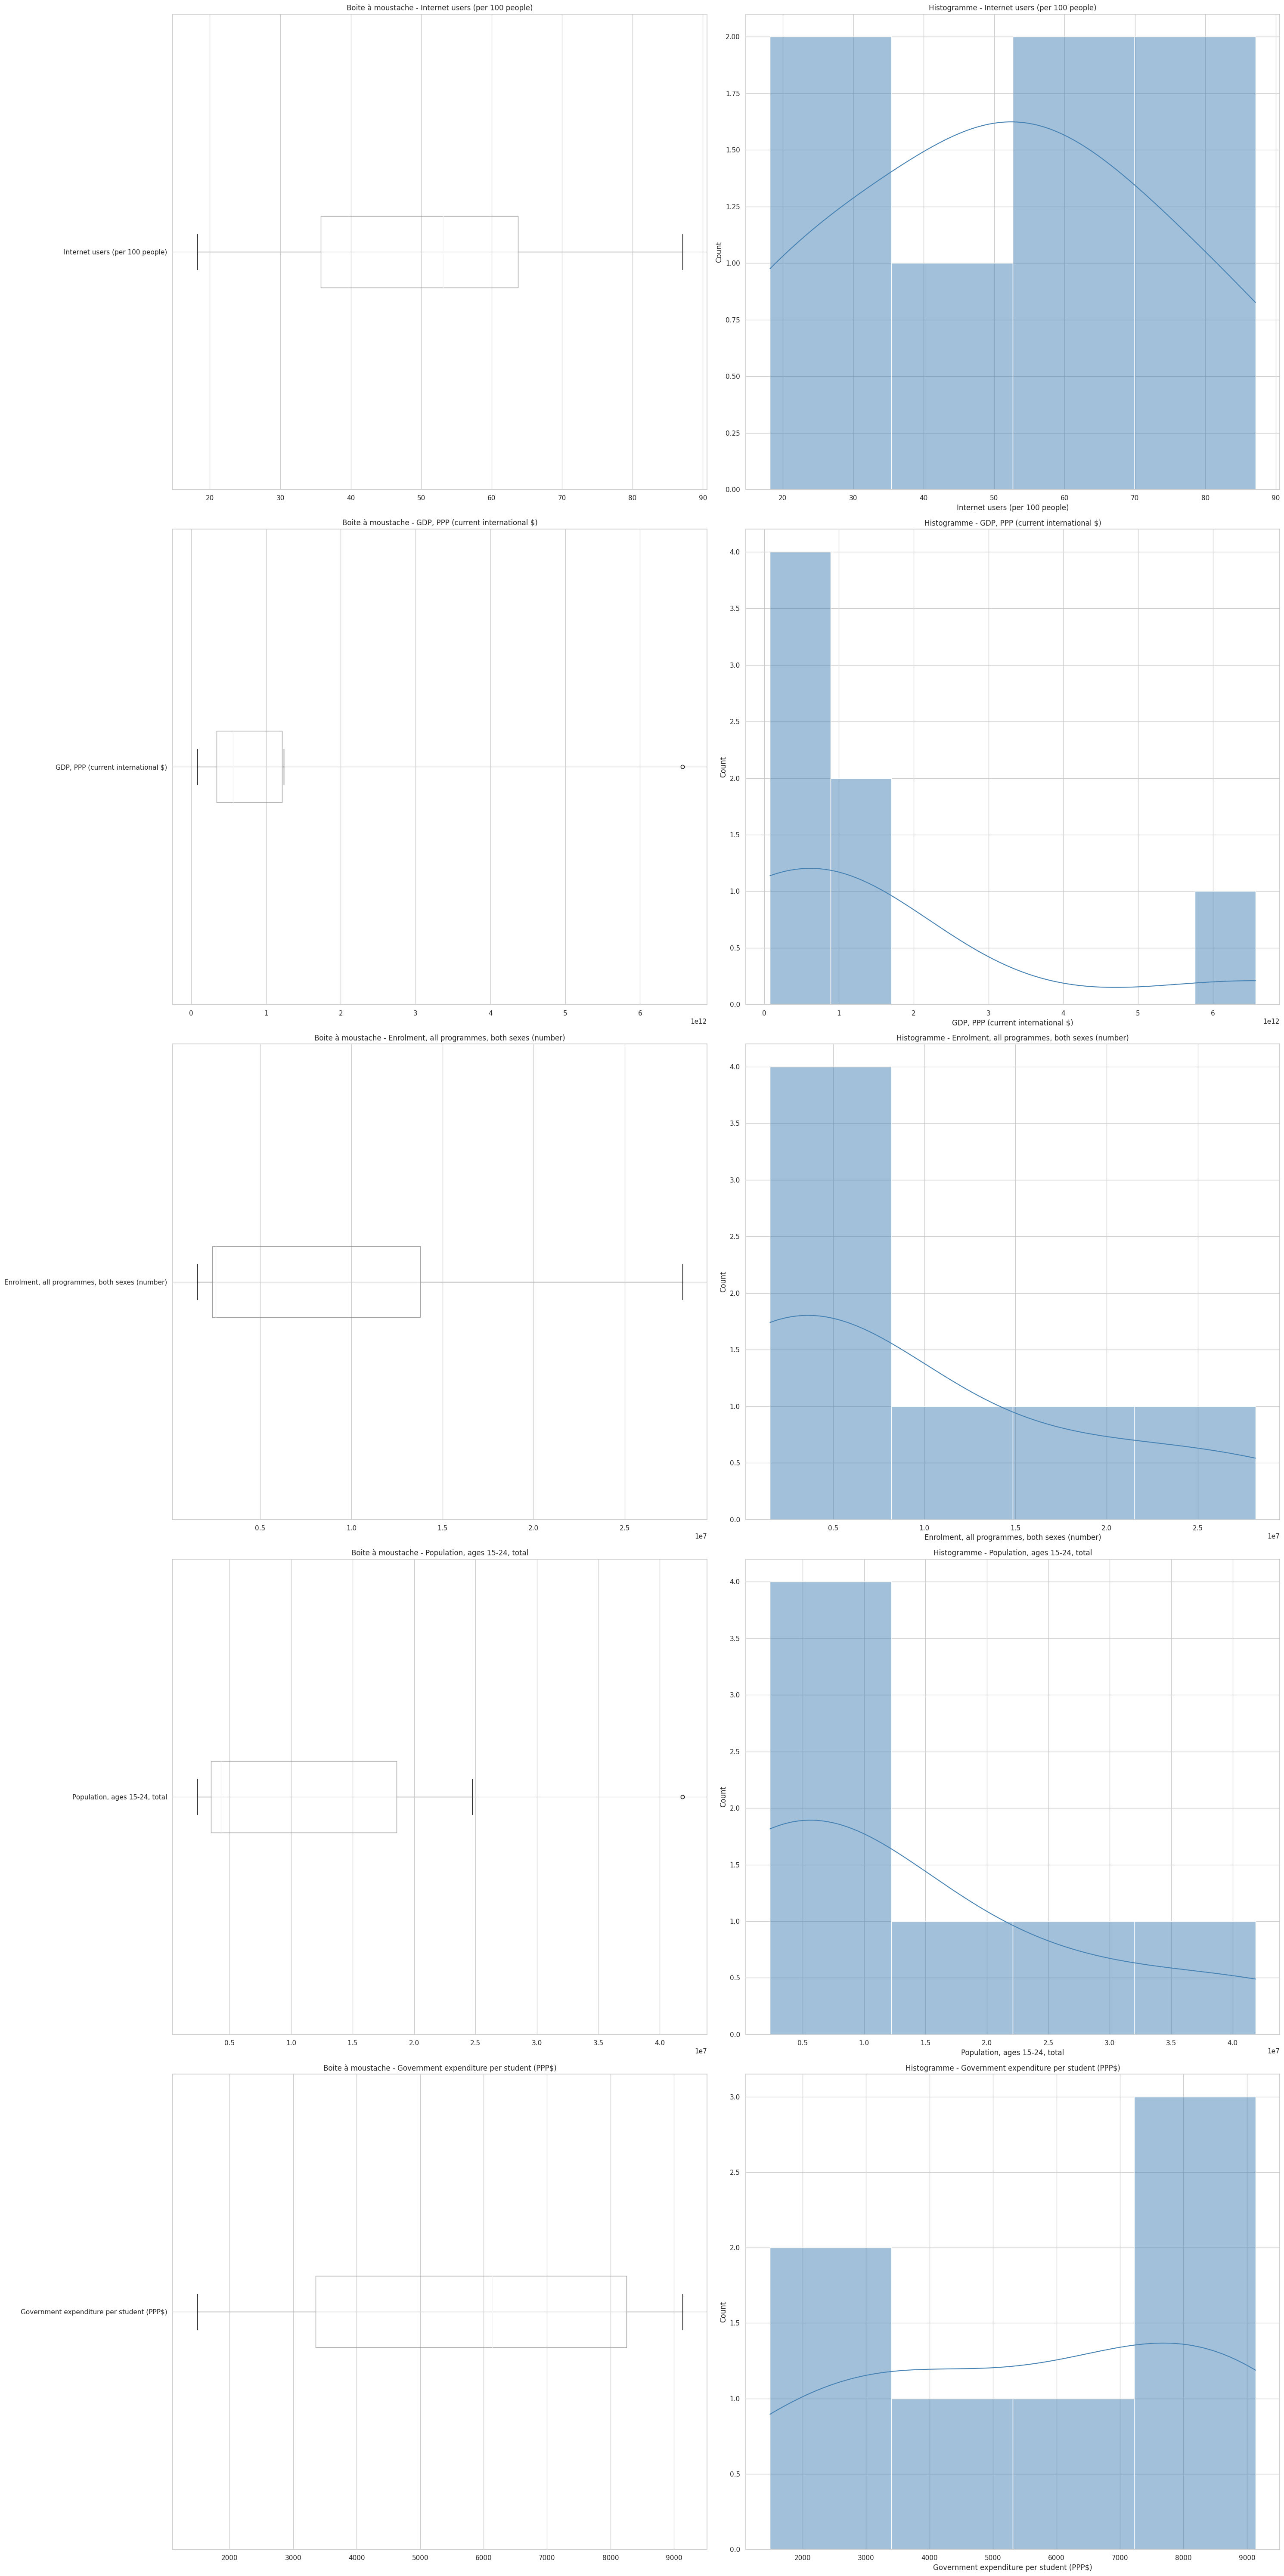

In [147]:
# Création des boîtes à moustache et histogramme

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(30, 60))

# boucle sur les indicateurs pour créer les graphiques
for i, indicateur in enumerate(chosen_indicator_name_2):
    # boite à moustache pour l'indicateur
    working_df_geo_block.boxplot(column=indicateur, vert=False, ax=axes[i][0])
    axes[i][0].set_title(f'Boite à moustache - {chosen_indicator_name_2[i]}')

    # histogramme pour l'indicateur
    sns.histplot(working_df_geo_block[indicateur], kde=True, color='SteelBlue', ax=axes[i][1])
    axes[i][1].set_title(f'Histogramme - {chosen_indicator_name_2[i]}')

plt.tight_layout()
plt.show()

Nous observons 2 outliers pour les indicateurs de la parité de pouvoir d'achat (Amérique du Nord) et pour la taille de la population (Asie du Sud).

Ces observations sont attendues au vu de, respectivement, la situation économique et de la densité de population.

La taille de l'échantillon étant faible (7), nous n'allons ni aborder la distribution des indicateurs ni les statistiques.

## B. Selon les pays

In [148]:
working_df_countries.describe().apply(lambda s: s.apply('{0:.0f}'.format))

Indicator Name GDP, PPP (current international $)  \
count                                         102   
mean                                 960768542943   
std                                 2830545118561   
min                                     614824668   
25%                                   30666071064   
50%                                  121051984828   
75%                                  521762752231   
max                                19852725477823   

Indicator Name Internet users (per 100 people) Population, ages 15-24, total  \
count                                      102                           102   
mean                                        51                       9393513   
std                                         29                      31449533   
min                                          2                         29869   
25%                                         22                        620706   
50%                                         54                       2167566   
75%                                         76                       5611388   
max                                         98                     244120201   

Indicator Name Government expenditure per student (PPP$)  \
count                                                102   
mean                                                5217   
std                                                 5439   
min                                                   23   
25%                                                 1378   
50%                                                 3135   
75%                                                 7673   
max                                                26663   

Indicator Name Enrolment, all programmes, both sexes (number)  
count                                                     102  
mean                                                  6414958  
std                                                  20996983  
min                                                     16003  
25%                                                    481829  
50%                                                   1112674  
75%                                                   3830314  
max                                                 161649476

Les statistiques montrent que sur les 102 pays étudiés :

  - En moyenne, il y a 9.3 millions de jeunes entre 18 et 24 ans pour 6.4 millions d’inscriptions (69%). Le marché est donc important

  - En moyenne, la moitié de la population utilise internet

  - Globalement, les écarts type montre une forte disparité notamment pour le PIB en PPP

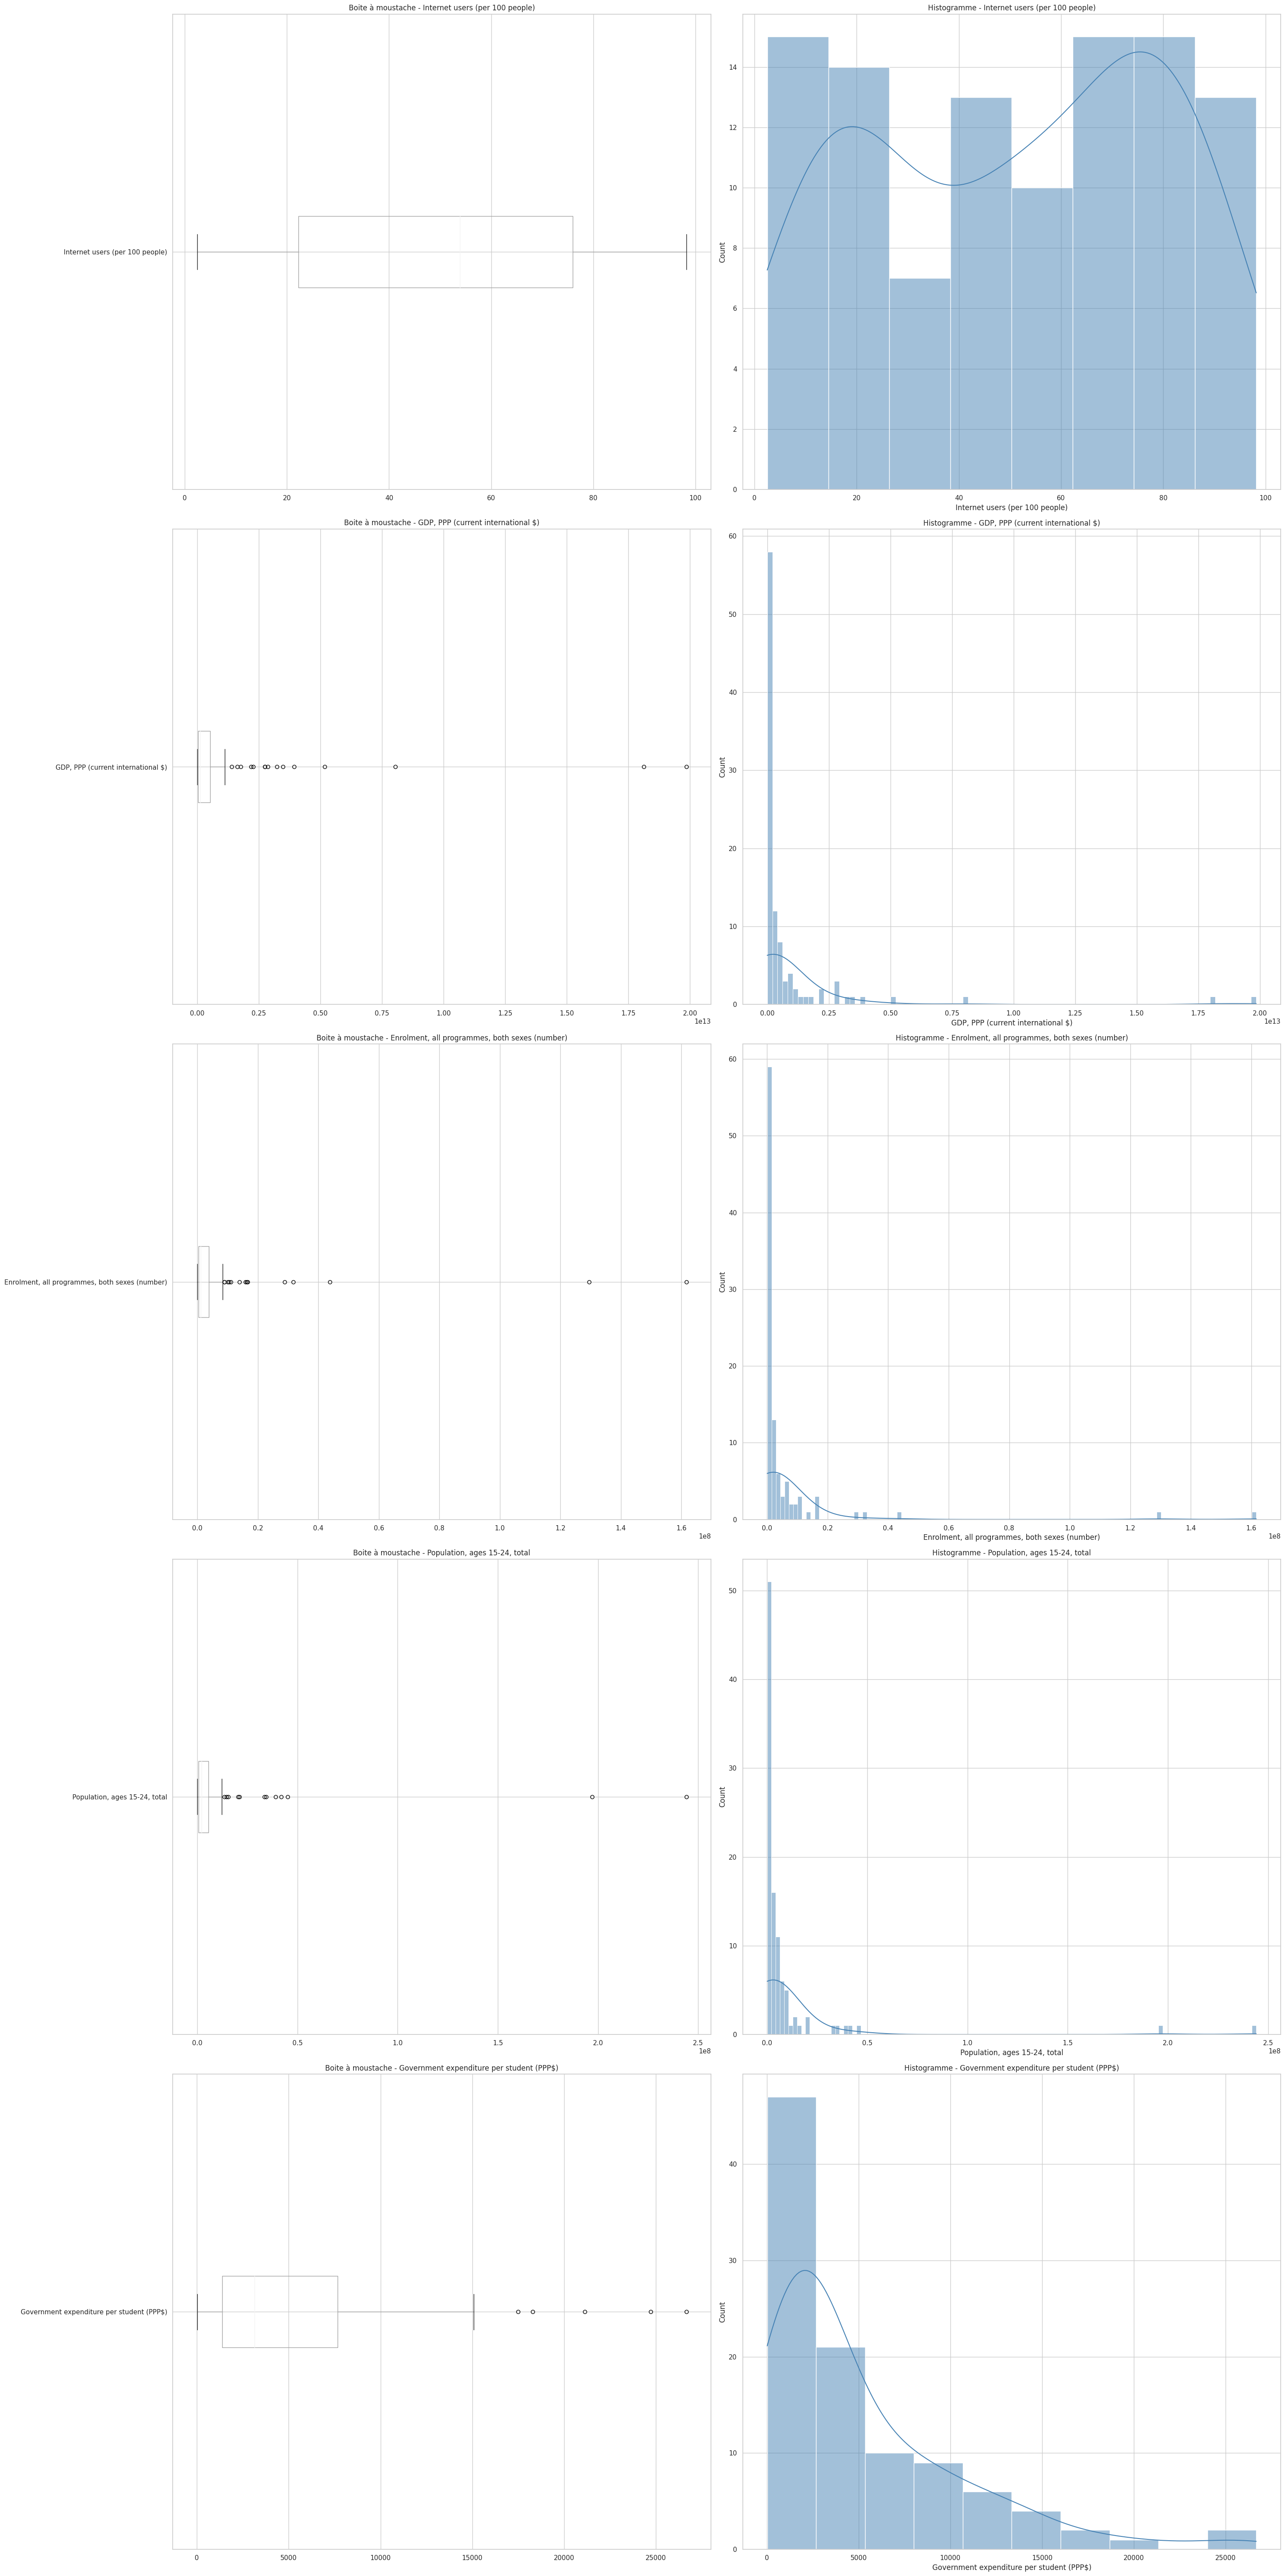

In [149]:
# Création des boîtes à moustache et histogramme

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(30, 60))

# boucle sur les indicateurs pour créer les graphiques
for i, indicateur in enumerate(chosen_indicator_name_2):
    # boite à moustache pour l'indicateur
    working_df_countries.boxplot(column=indicateur, vert=False, ax=axes[i][0])
    axes[i][0].set_title(f'Boite à moustache - {chosen_indicator_name_2[i]}')

    # histogramme pour l'indicateur
    sns.histplot(working_df_countries[indicateur], kde=True, color='SteelBlue', ax=axes[i][1])
    axes[i][1].set_title(f'Histogramme - {chosen_indicator_name_2[i]}')

plt.tight_layout()
plt.show()

**Internet User**

**Boite à moustache**:
Il n'y a pas de outlier pour l'indicateur Internet User contrairement aux  autre indicateurs (étant donnée que c'est un pourcentage).

**Histogramme**:
Pour l'indicateur Internet User, nous observons 3 pics ce qui pourraient suggérer que les données soient multimodales à 10%, 40% et 80%. Néanmoins, nous constatons que une différence de 5 pays entre le pic maximal et le minimum local à 55% ce qui laisse suggérer que les pics ne soient pas signicatifs.

---

**Government expenditure per student**

**Boite à moustache**:
Plus de 75% des pays dépensent moins de 7500 PPP\$.
Les pays dépensant plus de 15 000 PPP$ se compte sur les doigts d'une main.

**Histogramme**:
45 pays soit un peu moins de la moitié des pays dépensent peu pour l'éducation des étudiants dans le secondaire et dans le tertiaire (entre 0 et 2500 PPP$).
Cela montre un faible investissement dans l'éducation pour la plupart des pays.

Intéressons nous à l'étude de l'asymétrie et de l'applatissement des histogrammes.

In [150]:
# Analyse de l'asymétrie des histogrammes

skew_gdp=working_df_countries['GDP, PPP (current international $)'].skew()
skew_internet=working_df_countries['Internet users (per 100 people)'].skew()
skew_population=working_df_countries['Population, ages 15-24, total'].skew()
skew_expendure=working_df_countries['Government expenditure per student (PPP$)'].skew()
skew_enrolment=working_df_countries['Enrolment, all programmes, both sexes (number)'].skew()

kurtosis_gdp=working_df_countries['GDP, PPP (current international $)'].kurtosis()
kurtosis_internet=working_df_countries['Internet users (per 100 people)'].kurtosis()
kurtosis_population=working_df_countries['Population, ages 15-24, total'].kurtosis()
kurtosis_expendure=working_df_countries['Government expenditure per student (PPP$)'].kurtosis()
kurtosis_enrolment=working_df_countries['Enrolment, all programmes, both sexes (number)'].kurtosis()

hist_asymmetry = [
        ['skew', skew_gdp, skew_internet, skew_population, skew_expendure, skew_enrolment],
        ['kurtosis', kurtosis_gdp, kurtosis_internet, kurtosis_population, kurtosis_expendure, kurtosis_enrolment]]
hist_asymmetry = pd.DataFrame(hist_asymmetry,columns=['Variable','GDP','Internet users','Population','Expenditure','Enrolment'])
print(hist_asymmetry)

   Variable        GDP  Internet users  Population  Expenditure  Enrolment
0      skew   5.456441       -0.134460    6.375741     1.770098   6.191771
1  kurtosis  32.450378       -1.343459   42.875274     3.286650  40.852116


L'analyse de l'asymétrie montre 2 observations principales :

- Une forte asymétrie positive pour les indicateurs de parité de pouvoir d'achat (5.45), de population (6.38) et de nombre d'inscription (6.19). L'indicateur de la dépense de l'État par étudiant (1.77) est également positif.

- L'absence d'asymétrie pour l'indicateur du pourcentage d'utilisateurs d'internet car la valeur du skewness est proche de 0. La distribution est donc symétrique et nous pouvons nous intéresser au kurtosis.
Le kurtosis étant négatif, cela signifie que l'histogramme est plus aplati que la courbe de Gauss.

# **VII. Analyse des indicateurs - Double scoring**

Nous procéderons initialement à un scoring basé sur les données les plus récentes pour chaque indicateur.

Ensuite, nous sélectionnerons les 10 pays les mieux classés d'après ce premier scoring. Un second scoring sera réalisé en prenant en compte les valeurs prédites pour l'année 2025, afin d'affiner notre sélection.

## A. Scoring selon la valeur la plus récente de chaque indicateur

Pour notre méthode de scoring, nous avons opté pour l'approche des quantiles plutôt que celle des valeurs minimales et maximales, car l'amplitude importante des valeurs pourrait compresser les valeurs dans une petit intervalle.

---
Les zones géographiques sont évaluées sur une échelle de 20.

Les valeurs ont été divisées en quatre intervalles, permettant ainsi à chaque indicateur de contribuer jusqu'à 4 points au score total.

In [151]:
# Scoring des zones géographiques

for ind in chosen_indicator_name_2:
  bins = pd.qcut(working_df_geo_block[ind], 4)
  labels = range(1, 5)
  working_df_geo_block[f'Score_{ind}'] = pd.qcut(working_df_geo_block[ind], 4, labels=labels)
working_df_geo_block['final_score /20'] = working_df_geo_block[[f'Score_{ind}' for ind in chosen_indicator_name_2]].sum(axis=1)
columns_to_display = ['Region', 'final_score /20'] + [f'Score_{ind}' for ind in chosen_indicator_name_2]
print(working_df_geo_block[columns_to_display].sort_values(by='final_score /20', ascending = False))

Indicator Name                      Region  final_score /20  \
5                            North America             20.0   
0                      East Asia & Pacific             15.0   
6                               South Asia             14.0   
1                    Europe & Central Asia             11.0   
3               Middle East & North Africa             11.0   
2                Latin America & Caribbean              7.0   
7                       Sub-Saharan Africa              7.0   

Indicator Name Score_Internet users (per 100 people)  \
5                                                  4   
0                                                  2   
6                                                  1   
1                                                  4   
3                                                  3   
2                                                  2   
7                                                  1   

Indicator Name Score_GDP, PPP (current interna

Pour les zones géographiques, nous constatons que l'Amérique du Nord se trouve en première position, suivie de près par l'Asie de l'Est et du Sud.

---
Les pays sont évalués sur une échelle de 100.

Afin de discriminer davantage les pays, les valeurs ont été divisées en 20 intervalles (contre 4 pour les zones géographiques). Cela permet à chaque indicateur de contribuer jusqu'à 20 points au score total.

In [152]:
# Scoring des pays

for ind in chosen_indicator_name_2:
  bins = pd.qcut(working_df_countries[ind], 20)
  labels = range(1, 21)
  working_df_countries[f'Score_{ind}'] = pd.qcut(working_df_countries[ind], 20, labels=labels)
working_df_countries['final_score /100'] = working_df_countries[[f'Score_{ind}' for ind in chosen_indicator_name_2]].sum(axis=1)
columns_to_display = ['Country Name', 'final_score /100'] + [f'Score_{ind}' for ind in chosen_indicator_name_2]
scoring1 = working_df_countries[columns_to_display].sort_values(by='final_score /100', ascending = False).head(10)
print(scoring1)

Indicator Name        Country Name  final_score /100  \
94                           Japan              94.0   
201                  United States              93.0   
200                 United Kingdom              92.0   
70                         Germany              91.0   
65                          France              90.0   
156             Russian Federation              85.0   
100                    Korea, Rep.              84.0   
25                          Brazil              82.0   
174                          Spain              80.0   
136                    Netherlands              80.0   

Indicator Name Score_Internet users (per 100 people)  \
94                                                20   
201                                               15   
200                                               20   
70                                                19   
65                                                18   
156                                            

Dans le scoring des pays, nous identifions deux groupes distincts : les cinq premiers pays se situent entre 94 et 90 points, tandis que les cinq suivants se trouvent dans une fourchette de 85 à 80 points.

Ce premier scoring reflète le potentiel passé des pays. Il sera intéressant de comparer ces résultats avec les prédictions pour 2025 afin de voir si un classement similaire émerge. Pour ce faire, nous procéderons à un second scoring pour les 10 pays sélectionnés lors du premier classement.

## B. Scoring des 10 premiers pays selon les prédictions de 2025


Voyons s'il y a suffisamment de données disponibles dans le dataset data après 2024.

In [153]:
top10 = ['Japan', 'United States', 'United Kingdom', 'Germany', 'France', 'Russian Federation', 'Korea, Rep.', 'Brazil', 'Spain', 'Netherlands']
colonnes = ['Country Name', 'Indicator Name', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100']
year_prediction = ['2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100']
dfs = {} # dictionnaire qui contiendra tous les dataframes (1 dataframe = 1 indicateur)

for ind in chosen_indicator_name:
    # Filtrage du dataset original pour un indicateur spécifique et les pays du top 10
    df_temp = data_original.loc[(data_original["Country Name"].isin(top10)) & (data_original["Indicator Name"] == ind), colonnes]

    # Stockage du dataset filtré dans le dictionnaire dfs
    dfs[ind] = df_temp

    # Calcul et affichage du nombre total de données manquantes pour chaque dataset
    nombre_donnees_manquantes = df_temp.loc[: , year_prediction].notna().sum().sum()
    print(f"Nombre de données manquantes pour {ind}: {nombre_donnees_manquantes}")


Nombre de données manquantes pour Internet users (per 100 people): 0
Nombre de données manquantes pour GDP, PPP (current international $): 0
Nombre de données manquantes pour Enrolment in tertiary education, all programmes, both sexes (number): 0
Nombre de données manquantes pour Enrolment in secondary education, both sexes (number): 0
Nombre de données manquantes pour Population, ages 15-24, total: 0
Nombre de données manquantes pour Government expenditure per secondary student (PPP$): 0
Nombre de données manquantes pour Government expenditure per tertiary student (PPP$): 0


Il n'y a que des valeurs manquantes.

Nous allons procéder par des estimations grâce à des régressions linéaires qui s'appuient sur les valeurs entre 2010 et 2015.

### i. Préparation du dataset de travail et visualisation des droites de régression linéaire

In [154]:
# Nous estimons les valeurs manquantes comme dans la partie précédente pour avoir au moins une valeur entre 2010 et 2015

## Valeur manquante par un indicateur qui possède le même ordre de grandeur Allemagne
data_original.loc[(data_original['Country Name'] == 'Germany') & (data_original['Indicator Name'] == 'Government expenditure per tertiary student (PPP$)'), '2014'] = 10111.51
## Valeur manquante par un indicateur qui possède le même ordre de grandeur Russie
data_original.loc[(data_original['Country Name'] == 'Russian Federation') & (data_original['Indicator Name'] == 'Government expenditure per secondary student (PPP$)'), '2014'] = 3793.29


# Une régression linéaire nécessite 2 points minimum, nous duppliquons donc certaines valeurs
data_original.loc[(data_original['Country Name'] == 'Germany') & (data_original['Indicator Name'] == 'Government expenditure per tertiary student (PPP$)'), '2015'] = 10111.51
data_original.loc[(data_original['Country Name'] == 'Russian Federation') & (data_original['Indicator Name'] == 'Government expenditure per secondary student (PPP$)'), '2015'] = 3793.29
data_original.loc[(data_original['Country Name'] == 'Russian Federation') & (data_original['Indicator Name'] == 'Government expenditure per tertiary student (PPP$)'), '2015'] = 3793.29

In [155]:
# Création des dataframes

colonnes = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015']
dfs = {} # dictionnaire qui contiendra tous les dataframes (1 dataframe = 1 indicateur)

for ind in chosen_indicator_name:
    df_temp = data_original.loc[(data_original["Country Name"].isin(top10)) & (data_original["Indicator Name"] == ind), colonnes]
    df_melted = pd.melt(df_temp, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                        var_name='Year', value_name='Value',
                        value_vars=['2010', '2011', '2012', '2013', '2014', '2015'])
    dfs[ind] = df_melted

Visualisation des droites de régressions linéaires

equation de droite Brazil: valeur = 3.3557932654285723 x an + -6703.730787740002
equation de droite France: valeur = 1.5812086580000004 x an + -3101.0317077266677
equation de droite Germany: valeur = 1.2722572259999994 x an + -2476.4893676566653
equation de droite Japan: valeur = 2.946323696000002 x an + -5845.285637560004
equation de droite Korea, Rep.: valeur = 1.195322094857143 x an + -2320.00161965
equation de droite Netherlands: valeur = 0.19591737171428553 x an + -302.22584523333296
equation de droite Russian Federation: valeur = 6.307999999999999 x an + -12633.566666666666
equation de droite Spain: valeur = 2.673514339714286 x an + -5308.91184212
equation de droite United Kingdom: valeur = 1.6015887408571423 x an + -3134.644941479999
equation de droite United States: valeur = 0.5952179991428588 x an + -1125.3639460733366


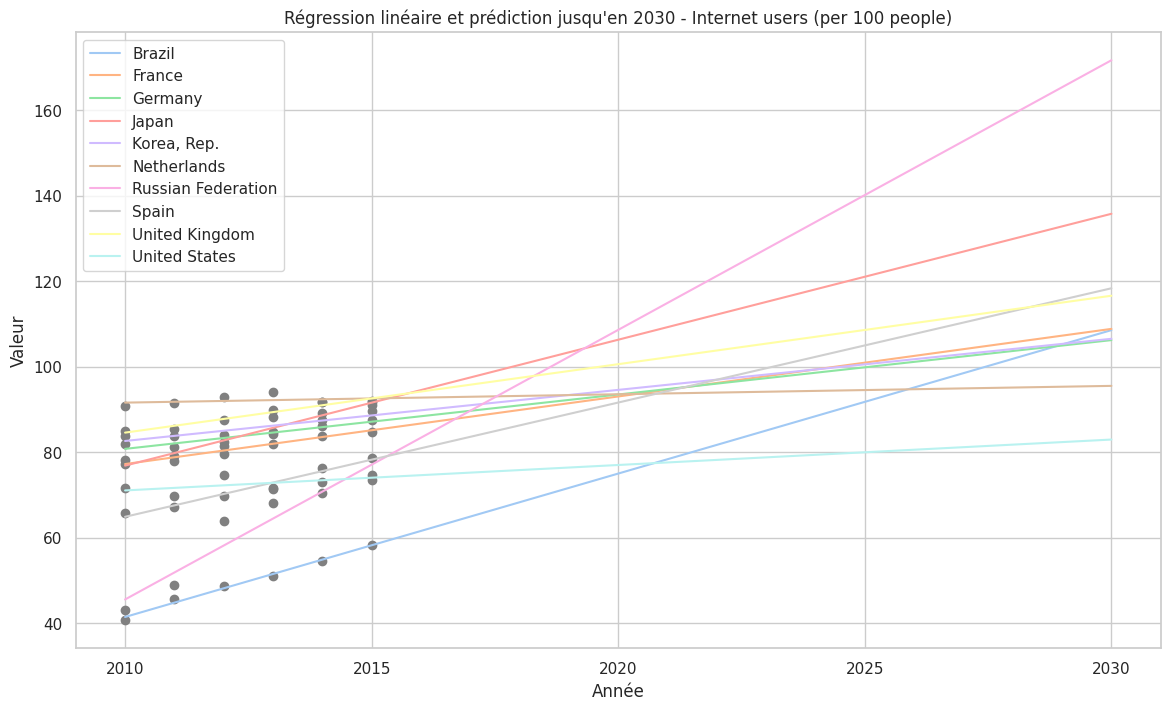

--------------------------
equation de droite Brazil: valeur = 92465819094.08858 x an + -182982830340401.75
equation de droite France: valeur = 79974569208.51799 x an + -158402212106946.03
equation de droite Germany: valeur = 141398240782.36227 x an + -280972908213597.97
equation de droite Japan: valeur = 142692260904.87457 x an + -282342377226176.9
equation de droite Korea, Rep.: valeur = 49394596077.42262 x an + -97776041311908.52
equation de droite Netherlands: valeur = 21244404952.277836 x an + -41956916496693.74
equation de droite Russian Federation: valeur = 100676195328.2246 x an + -199101879619043.12
equation de droite Spain: valeur = 24732283643.08712 x an + -48242279052810.28
equation de droite United Kingdom: valeur = 102107486499.98828 x an + -203010107609630.97
equation de droite United States: valeur = 626957228571.4286 x an + -1245277608000000.0


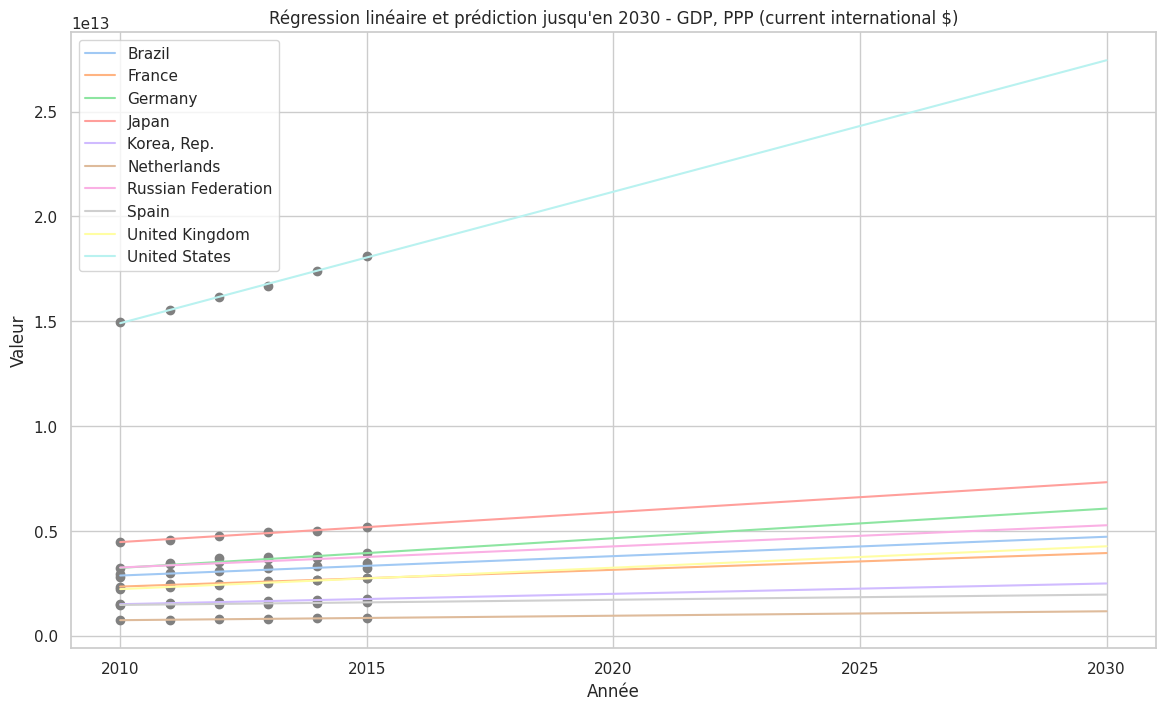

--------------------------
equation de droite Brazil: valeur = 354057.5142857143 x an + -705103719.3333334
equation de droite France: valeur = 36625.299999999996 x an + -71384530.39999999
equation de droite Germany: valeur = 98884.12499999997 x an + -196262628.6666666
equation de droite Japan: valeur = 3449.700000000001 x an + -3075455.4000000022
equation de droite Korea, Rep.: valeur = -3932.485714285713 x an + 11233115.666666664
equation de droite Netherlands: valeur = 31855.64285714285 x an + -63326753.92857142
equation de droite Russian Federation: valeur = -510776.1000000001 x an + 1035742695.1000001
equation de droite Spain: valeur = 14953.685714285717 x an + -28142495.333333336
equation de droite United Kingdom: valeur = -35861.35 x an + 74594314.55
equation de droite United States: valeur = -269974.45714285714 x an + 563597348.0


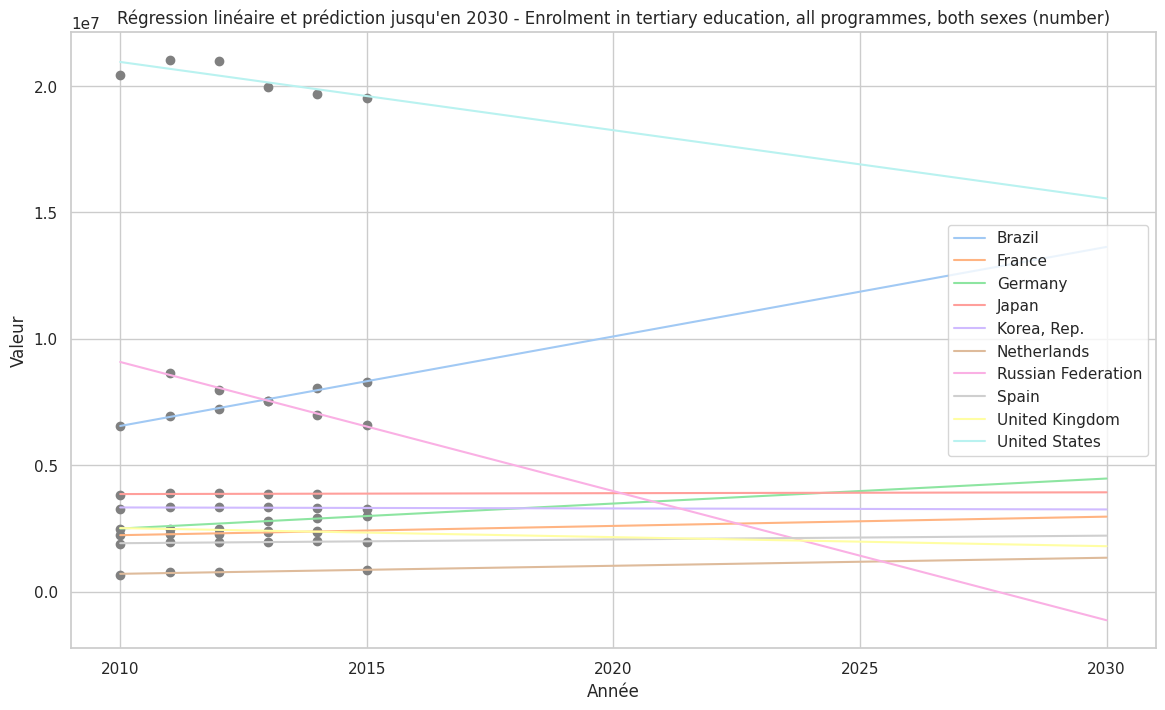

--------------------------
equation de droite Brazil: valeur = 115407.37142857145 x an + -208477284.00000006
equation de droite France: valeur = 17367.899999999998 x an + -29035661.199999996
equation de droite Germany: valeur = -109691.37142857145 x an + 228118617.66666672
equation de droite Japan: valeur = -14179.800000000001 x an + 35805332.6
equation de droite Korea, Rep.: valeur = -108045.31428571428 x an + 221162309.0
equation de droite Netherlands: valeur = 23419.88571428572 x an + -45578594.66666667
equation de droite Russian Federation: valeur = 25279.8 x an + -41706345.4
equation de droite Spain: valeur = 21772.657142857148 x an + -40546295.00000001
equation de droite United Kingdom: valeur = 353416.39999999997 x an + -705385436.5
equation de droite United States: valeur = -4486.400000000003 x an + 33197589.200000003


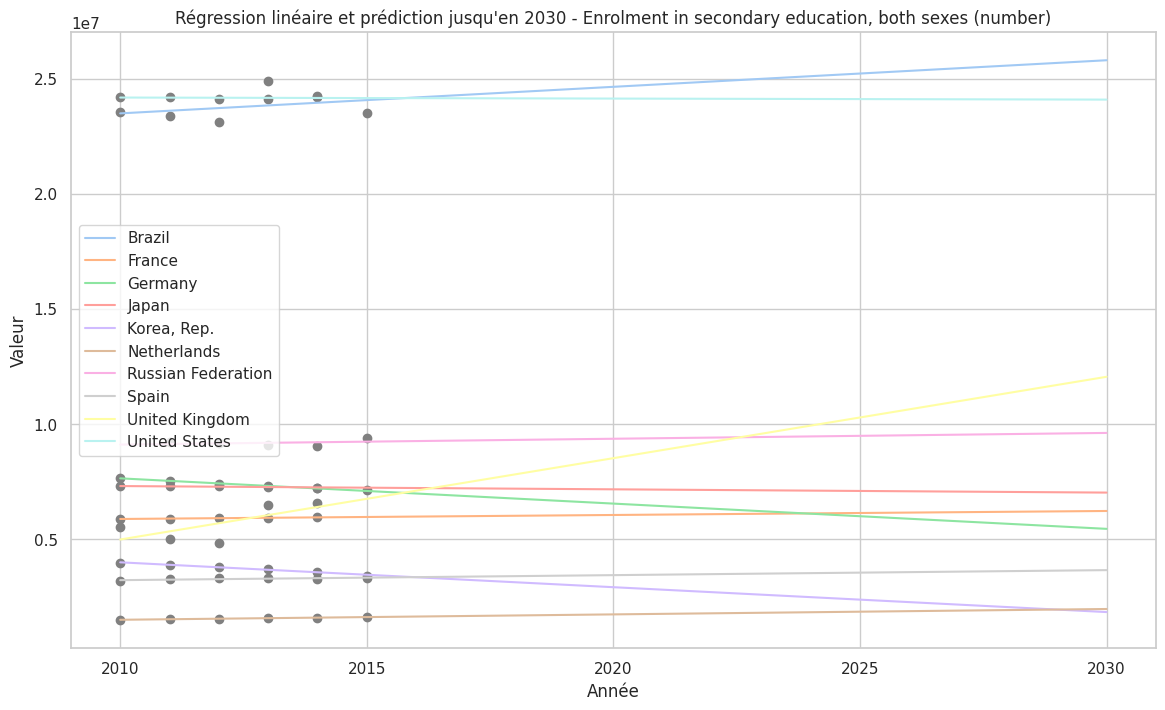

--------------------------
equation de droite Brazil: valeur = -26852.171428571433 x an + 87571253.33333334
equation de droite France: valeur = -14449.457142857149 x an + 36662450.66666668
equation de droite Germany: valeur = -142462.6 x an + 295742851.6666667
equation de droite Japan: valeur = -93321.5714285714 x an + 200160725.99999994
equation de droite Korea, Rep.: valeur = -28576.71428571429 x an + 64077090.33333334
equation de droite Netherlands: valeur = 1540.3714285714286 x an + -1097460.6666666667
equation de droite Russian Federation: valeur = -1124475.4285714284 x an + 2280287245.666666
equation de droite Spain: valeur = -64717.28571428573 x an + 134659647.6666667
equation de droite United Kingdom: valeur = -61862.57142857141 x an + 132403132.99999997
equation de droite United States: valeur = -5126.485714285712 x an + 55560736.66666666


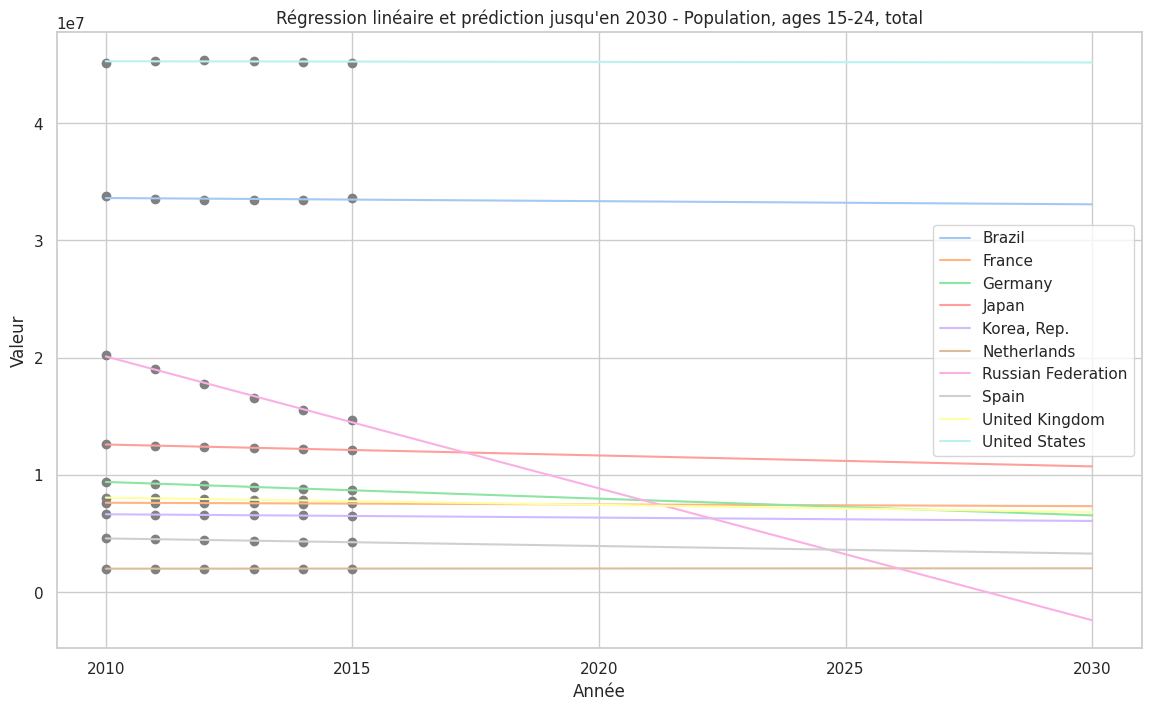

--------------------------
equation de droite Brazil: valeur = 254.69189453124991 x an + -508915.48917643214
equation de droite France: valeur = -74.05322265624999 x an + 159027.49300130206
equation de droite Germany: valeur = 325.7753906249999 x an + -645341.0058593748
equation de droite Japan: valeur = 434.6232421874999 x an + -865663.7888671873
equation de droite Korea, Rep.: valeur = 397.3408203124999 x an + -792238.3764648435
equation de droite Netherlands: valeur = -3.149023437500005 x an + 17611.48134765626
equation de droite Russian Federation: valeur = 0.0 x an + 3793.29
equation de droite Spain: valeur = -399.6348702566965 x an + 811852.4990234376
equation de droite United Kingdom: valeur = -1118.7473493303576 x an + 2260486.063476563
equation de droite United States: valeur = -41.5703125 x an + 95057.35807291667


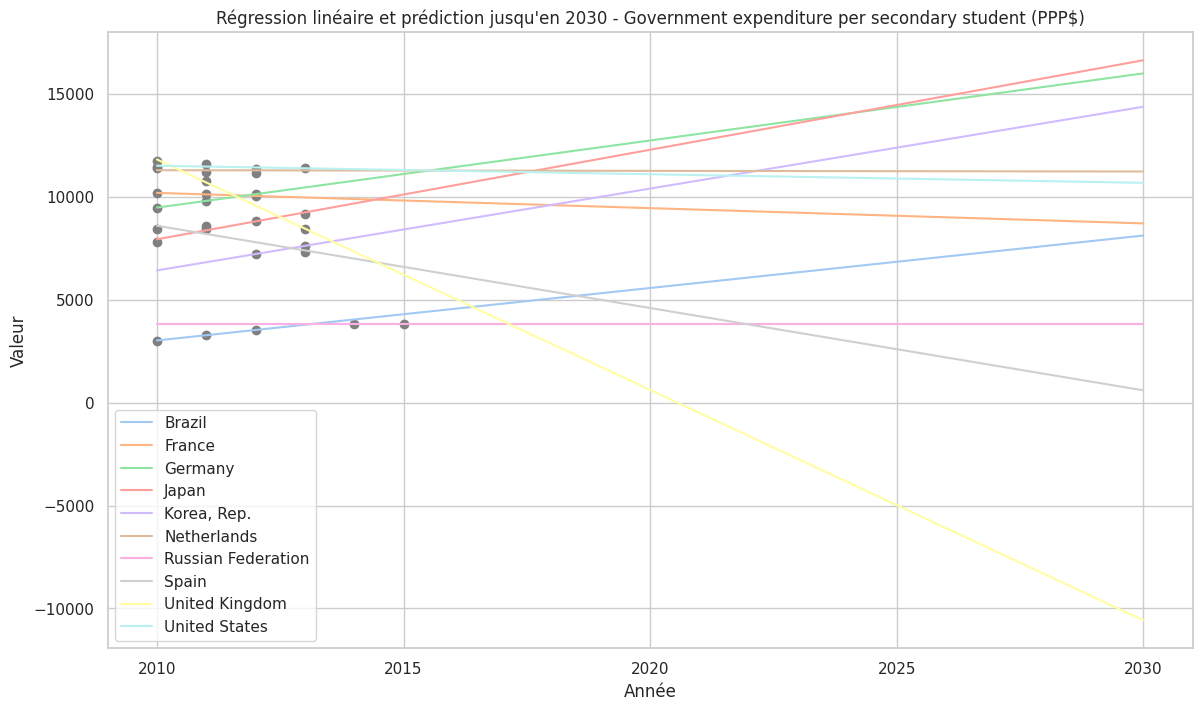

--------------------------
equation de droite Brazil: valeur = 77.44445800780997 x an + -151671.02909341938
equation de droite France: valeur = -96.6513671875 x an + 207731.19694010416
equation de droite Germany: valeur = 0.0 x an + 10111.51
equation de droite Japan: valeur = 326.33227539062494 x an + -647918.3356933593
equation de droite Korea, Rep.: valeur = 790.4826660156199 x an + -1587101.4567870991
equation de droite Netherlands: valeur = -1182.5297851562495 x an + 2394458.015462239
equation de droite Russian Federation: valeur = -0.0012337239600128664 x an + 3795.7759537794254
equation de droite Spain: valeur = -615.0252929687498 x an + 1245368.278662109
equation de droite United Kingdom: valeur = 1521.0055803571433 x an + -3047891.4599609384
equation de droite United States: valeur = -100.90136718749994 x an + 212625.70410156238


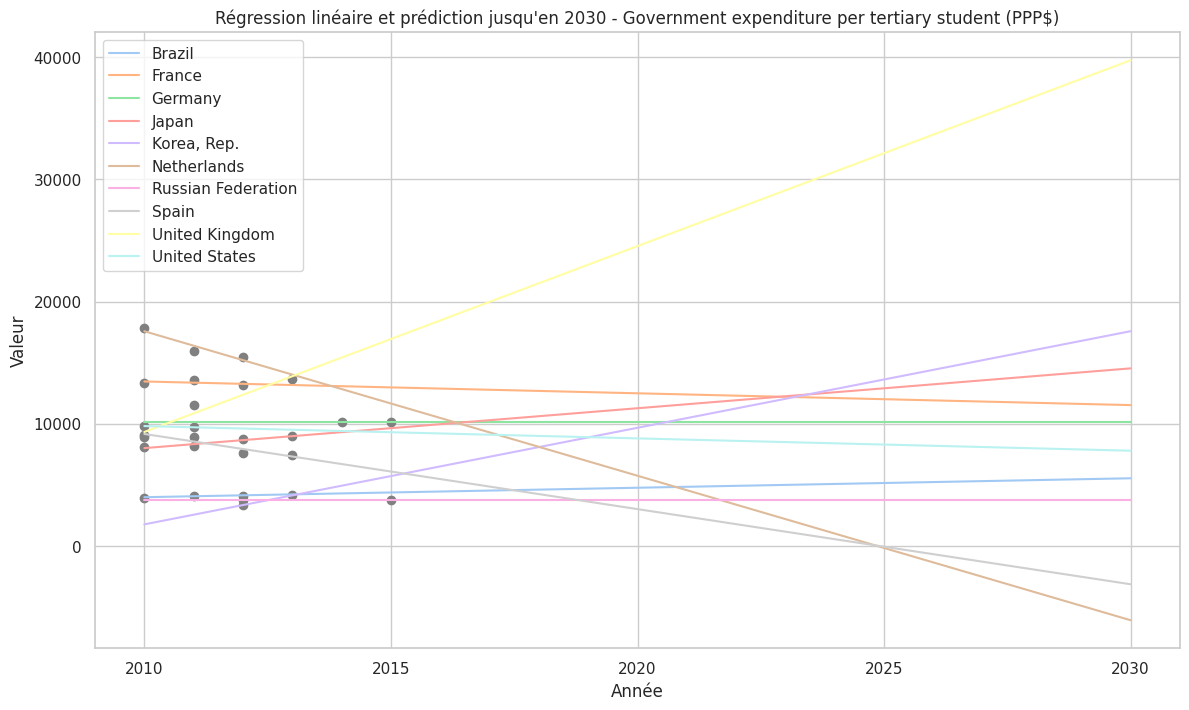

--------------------------


In [156]:
# Création d'un graphe pour chaque indicateur et conservation des coeffients des droites de régressions linéaires
equations_list = [] # Un élément est sous le format suivant : [indicateur, pays, modele.coef_[0], modele.intercept_]

for ind, df in dfs.items():
    regression_per_indicator(df, ind, equations_list)
    print('--------------------------')

### ii. Préparation de la donnée pour le scoring

Nous allons créer un dataframe dans lequel nous calculerons les valeurs estimées de chaque indicateur en 2025.

Faisons un scoring pour les valeurs estimées en 2025.

In [157]:
# Création du dataframe de travail avec le même format que les éléments dans equations_list ([indicateur, pays, modele.coef_[0], modele.intercept_])

df_prediction = pd.DataFrame({'Indicator Name': pd.Series(dtype='str'),
                              'Country Name': pd.Series(dtype='str'),
                              'coef': pd.Series(dtype='int'),
                              'intersect': pd.Series(dtype='int')})


# Remplir le dataframe avec les valeurs de la liste equations_list

for equation in equations_list:
  df_prediction.loc[len(df_prediction)] = equation


# Estimation des valeurs en 2025 d'après les modèles de régressions linéaires

df_prediction['estimation_2025'] = df_prediction['coef']*2025 + df_prediction['intersect']


# Formatage du dataframe pour avoir 1 ligne = 1 pays

df_prediction = df_prediction.pivot_table(values = 'estimation_2025', index = 'Country Name', columns = 'Indicator Name')
df_prediction.reset_index(inplace = True)

### iii. Résultat du scoring

In [158]:
# Rassemblement des indicateurs du secondaire avec ceux du tertaire pour 2 indicateurs

df_prediction['Government expenditure per student (PPP$)'] =  0.5 * (df_prediction['Government expenditure per secondary student (PPP$)'] + df_prediction['Government expenditure per tertiary student (PPP$)'])
df_prediction['Enrolment, all programmes, both sexes (number)'] =  df_prediction['Enrolment in secondary education, both sexes (number)'] + df_prediction['Enrolment in tertiary education, all programmes, both sexes (number)']

df_prediction.drop(axis = 1,
                  columns = ['Government expenditure per secondary student (PPP$)',
                             'Government expenditure per tertiary student (PPP$)',
                             'Enrolment in secondary education, both sexes (number)',
                             'Enrolment in tertiary education, all programmes, both sexes (number)'], inplace = True)

chosen_indicator_name_2 = ['Internet users (per 100 people)', 'GDP, PPP (current international $)', 'Enrolment, all programmes, both sexes (number)', 'Population, ages 15-24, total', 'Government expenditure per student (PPP$)']

In [159]:
# Scoring

for ind in chosen_indicator_name_2:
  bins = pd.qcut(df_prediction[ind], 20)
  labels = range(1, 21)
  df_prediction[f'Score_{ind}'] = pd.qcut(df_prediction[ind], 20, labels=labels)
df_prediction['final_score /100'] = df_prediction[[f'Score_{ind}' for ind in chosen_indicator_name_2]].sum(axis=1)
columns_to_display = ['Country Name', 'final_score /100'] + [f'Score_{ind}' for ind in chosen_indicator_name_2]

scoring2 = df_prediction[columns_to_display].sort_values(by='final_score /100', ascending = False)
print(scoring2)

Indicator Name        Country Name  final_score /100  \
3                            Japan              86.0   
9                    United States              70.0   
8                   United Kingdom              68.0   
0                           Brazil              58.0   
2                          Germany              58.0   
1                           France              52.0   
6               Russian Federation              52.0   
4                      Korea, Rep.              40.0   
7                            Spain              28.0   
5                      Netherlands              13.0   

Indicator Name Score_Internet users (per 100 people)  \
3                                                 18   
9                                                  1   
8                                                 16   
0                                                  3   
2                                                  7   
1                                              

Moyenne des 2 scorings /100

In [160]:
# fusion des dataframe sur 'Country Name'
merged_df_mean = pd.merge(scoring1, scoring2, on='Country Name', suffixes=('_1', '_2'))

# calcul de la somme des scores finaux pour chaque pays
merged_df_mean['mean_final_score /100'] = (merged_df_mean['final_score /100_1'] + merged_df_mean['final_score /100_2'])/2

# création du troisième dataframe avec les résultats
df_mean = merged_df_mean[['Country Name', 'mean_final_score /100']].sort_values(by='mean_final_score /100', ascending = False)
print(df_mean)

Indicator Name        Country Name  mean_final_score /100
0                            Japan                   90.0
1                    United States                   81.5
2                   United Kingdom                   80.0
3                          Germany                   74.5
4                           France                   71.0
7                           Brazil                   70.0
5               Russian Federation                   68.5
6                      Korea, Rep.                   62.0
8                            Spain                   54.0
9                      Netherlands                   46.5


# **Conclusion**



Pour conclure, nous avons vu que les 2 scorings donnent deux podiums identiques.

Sur le podium, sont présents : le Japon (90/100), les Etats-Unis (82/100) et enfin le Royaume-Uni (80/100).

---

Si on regarde dans le détail sur le scoring par pays en 2025, si la stratégie de la start up est de s'appuyer sur un financement de l'Etat, il est intéressant de se concentrer davantage sur les Etats-Unis (20/20) ou le Royaume-Uni (18/20) au lieu du Japon (9/20).

En terme de pouvoir d'achat et de la demande potentielle (nombre d'étudiants), le Royaume-Uni se situe derrière le Japon et les Etats-Unis.

A noter que l'indicateur du nombre d'utilisateurs d'internet a déclassé les Etats-Unis (1/20) par rapport aux 2 autres pays du podium. Or, nous savons qu'il n'y a aucun problème sur ce sujet dans le pays.

---

Dans notre étude, nous avons choisi d'étudier la population entre 18 et 24 ans. Le podium a été déterminé sur cette population et donc sur les indicateurs dans l'éducation secondaire et tertiaire.

Pour aller plus loin, nous aurions besoin de davantage de contexte. Voici quelques suggestions :
- Modifier le choix des indicateurs
  - Choisir d'autres indicateurs
  - Supprimer l'indicateur des subventions de l'Etat
- Modifier la méthode de scoring
  - Pondérer les indicateurs en fonction de nos objectifs
  - Etudier séparément les indicateurs du secondaire et du tertiaire en fonction des priorités
  - Ne pas utiliser l'indicateur du % d'utilisateurs d'internet dans le scoring de prédiction car c'est un indicateur de faisabilité et à priori tous les pays du top 10 n'ont pas cette contrainte
- Restreindre les pays potentiels à un continent ou à une langue par exemple.
- Améliorer le résultat de nos régressions linéaires en prenant des valeurs plus récentes car l'écart entre 2015 et 2025 est de 10 ans ce qui rend la prédiction moins précise.
